In [177]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.optimizers import Adam, SGD, Adadelta

In [178]:
x_train_scaled = pd.read_csv('260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [179]:
x_test_scaled = pd.read_csv('260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [180]:
full_ds = pd.concat([x_train_scaled, x_test_scaled])
full_ds

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [181]:
train_set = x_train_scaled.copy()

In [182]:
test_set = x_test_scaled.copy()

### Dimensionality reduction with PCA

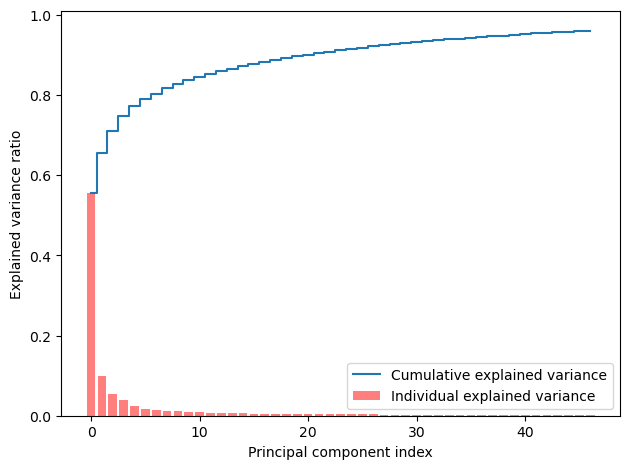

In [183]:
#https://vitalflux.com/pca-explained-variance-concept-python-example/#google_vignette

pca = PCA()
pca = PCA(n_components=.96)
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(train_set)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='r',label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [184]:
# https://www.datacamp.com/tutorial/principal-component-analysis-in-python

def encode_pca(dataset):
    pca_x_test = PCA(n_components=32)
    principalComponents_x_test = pca_x_test.fit_transform(dataset)
    if isinstance(dataset,np.ndarray):
        index = None
    else:
        index=dataset.index
    pca_x_test_ds = pd.DataFrame(data = principalComponents_x_test, 
                                       index=index)
    return pca_x_test_ds, pca_x_test

full_pca_dataset, pca_x = encode_pca(full_ds)
split_pt = int(0.7 * len(full_pca_dataset))
pca_test_dataset = full_pca_dataset[split_pt:]
pca_train_dataset = full_pca_dataset[:split_pt]

In [185]:
pca_train_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,-1.400480,0.036085,0.633785,0.991954,1.244477,1.137486,0.029610,0.658527,1.078466,-0.619487,...,0.470832,0.133802,-0.203272,-0.410425,0.186449,0.298332,-0.400682,0.767596,0.619227,0.085812
168_CD_plain,0.343929,-0.897671,0.955659,-0.201677,0.422730,-0.572408,0.003687,0.056367,0.171045,0.062771,...,0.027877,-0.336420,-0.175358,0.370251,-0.039556,0.055334,0.058026,0.161180,0.149297,-0.265662
72_control,-2.307192,-0.267483,1.578081,0.496850,-0.234867,0.234571,0.184197,0.036992,-0.068803,-0.119890,...,0.183052,0.194263,0.234877,0.178692,0.362024,-0.116276,-0.019640,-0.014161,0.195361,-0.416527
120_control,0.352933,-1.007575,-0.545913,0.208984,-0.308962,-0.011900,-0.357425,0.045246,-0.176911,-0.057539,...,0.046615,0.026036,-0.092182,0.198564,0.214210,-0.068817,0.149709,-0.144454,-0.024551,-0.078279
258_CD_plain,-1.060160,-0.005791,-0.675548,0.336661,-0.086003,0.094171,-0.527973,-0.092358,0.061105,0.117648,...,-0.081974,-0.346245,0.006149,0.066966,-0.062242,0.032586,0.045676,0.160777,-0.083701,-0.201276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.518700,2.631580,0.914480,-1.113737,-0.453870,-0.297425,0.328632,0.365649,0.381446,0.426910,...,-0.247678,-0.078042,0.051630,-0.065564,0.249531,-0.063245,0.432105,-0.029305,0.191425,-0.047575
182_CD_plain,0.876848,-0.873024,-0.229033,-0.623545,0.243320,0.249689,0.376666,-0.193785,-0.063964,-0.053892,...,0.198387,0.005078,0.106484,-0.248362,-0.114181,-0.104506,-0.110896,-0.119660,0.091979,0.218882
164_CD_plain,-1.977341,1.297043,-0.604174,0.409995,0.269979,0.258461,-0.132664,-0.176443,-0.008317,0.210307,...,-0.170181,0.229245,-0.190584,0.244012,0.039333,-0.238115,-0.067049,0.050171,0.149764,0.065102


In [186]:
# pca_train_dataset.to_csv("pca_train_dataset.csv")

In [187]:
print('Explained variation per principal component: {}'.format(pca_x.explained_variance_ratio_))
print("Total variance explained:",np.sum(pca_x.explained_variance_ratio_))

Explained variation per principal component: [0.56341432 0.09078083 0.05353027 0.03828962 0.02544877 0.01561396
 0.01497484 0.01148111 0.00990578 0.00885767 0.0079122  0.00719717
 0.0069242  0.00666156 0.00566338 0.00530329 0.00482758 0.00458454
 0.00434476 0.00417284 0.00393261 0.00377049 0.00365348 0.00344381
 0.00332665 0.00316007 0.00306275 0.0028374  0.00266067 0.00265178
 0.0025068  0.00232299]
Total variance explained: 0.927218204658128


In [188]:
# pc1_var, pc2_var = np.round(pca_x_test.explained_variance_ratio_ * 100, 1)
# pc1_var

### Dimensionality reduction with autoencoder

In [189]:
def load_encoder():
    n_inputs = 219
    n_bottleneck = 32
    encoder = Sequential(
                [

    #                 Input(shape=(n_inputs,)),
                    # encoder level 1
                    Dense(n_inputs*2),
                    BatchNormalization(),
                    LeakyReLU(),
                    # encoder level 2
                    Dense(n_inputs),
                    BatchNormalization(),
                    LeakyReLU(),
                    # bottleneck
                    Dense(n_bottleneck)
                ]
            )

    sh = test_set.head(1).shape
    encoder.load_weights("encoder_ckpt")
    encoder.build(sh) 
#     encoder.summary()
    return encoder

In [190]:
def ae_encode_dataset(dataset):
    encoder = load_encoder()
    latent_var = np.arange(32)
    print(type(dataset))
    if isinstance(dataset,np.ndarray):
        recon = encoder(dataset)
        index=None
    else:
        recon = encoder(dataset.values)
        index = dataset.index
    r = pd.DataFrame(recon, columns=latent_var, index=index)
    return r
    
full_ae_dataset = ae_encode_dataset(full_ds)

split_pt = int(0.7 * len(full_ae_dataset))
ae_test_dataset = full_ae_dataset[split_pt:]
ae_train_dataset = full_ae_dataset[:split_pt]

<class 'pandas.core.frame.DataFrame'>


In [191]:
ae_train_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,2.884348,-4.333632,1.534629,0.357453,0.831423,-0.201379,-0.335116,1.899084,-1.299261,-0.198478,...,2.173890,0.097263,0.444464,0.296948,1.785042,-0.130478,1.609985,2.002768,0.458599,0.722745
168_CD_plain,1.049997,0.968498,-0.634117,-1.679890,1.635449,-2.056087,-0.223816,1.611414,-0.198338,-1.088065,...,0.259527,-1.898594,-0.041199,-1.653017,-2.995473,-1.641031,-1.288697,0.736618,1.602979,-2.933374
72_control,1.775126,-4.049808,1.087583,1.459852,1.401432,0.852619,2.032758,0.495711,-0.845361,-0.557329,...,0.797558,1.375275,0.568535,2.058962,5.145083,-0.905856,0.867203,3.922681,3.519151,5.548365
120_control,0.117591,0.435450,-0.473291,-1.583053,0.799566,-2.394346,-0.706611,0.784904,0.150020,-2.133907,...,-0.543700,-0.798991,-0.046313,-1.795849,-3.107322,-0.769194,-2.614375,1.161695,0.380128,-3.846728
258_CD_plain,0.443390,-0.772829,0.884035,-0.374245,-0.443627,0.055477,-0.811601,0.414232,-0.582810,-0.579333,...,-0.419681,1.280246,0.369904,-0.106852,2.210283,-1.252376,0.158098,1.858046,0.539129,0.515659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,-3.672475,0.834738,1.542264,2.185633,-1.834641,3.122175,-1.350632,-2.351135,0.525460,3.629492,...,0.510670,-0.614047,2.294713,4.817264,1.498689,3.247430,3.975865,-4.355250,-1.201291,4.786653
182_CD_plain,-0.037418,1.366161,-0.056551,-1.735336,0.798326,-1.246346,-0.713014,0.526173,0.040249,-0.985651,...,0.190898,-0.660282,-0.221193,-1.727492,-3.602331,0.124196,-1.659816,-0.023671,-0.760651,-3.536419
164_CD_plain,0.310530,-2.311946,2.365372,1.838397,-1.330654,1.877666,-0.140262,-0.564555,-1.049672,0.395509,...,0.349844,2.943312,1.415317,2.549941,6.379101,-1.128445,1.433520,1.920403,0.837956,5.438933


## True labels

In [192]:
train_patient_ids = np.array(pca_train_dataset.index)


In [193]:
test_patient_ids = np.array(pca_test_dataset.index)


In [194]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

train_disease_labels = vec(train_patient_ids)
test_disease_labels = vec(test_patient_ids)

In [195]:
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

## KMeans clustering

### Fit KMeans (PCA & tSNE dimensionality reduction)

In [196]:
def compute_silh_scores(datapoints, cluster_labels):
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(datapoints, cluster_labels)


    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(datapoints, cluster_labels)
    
    return silhouette_avg, sample_silhouette_values

def plot_silhouette(n_clusters, cluster_labels, sample_silhouette_values, silhouette_avg, ax):
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [197]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html


def plot_kmeans(Y, disease_labels, k_labels, centers, radii, reduction, num_c=4, test_set=True, plot_sil=False, selected_patient_idx=None):

    num_rows = 2 if plot_sil else 1
    dim_h = 12 if plot_sil else 6
    dim_w = 15 if plot_sil else 15
    (fig, subplots) = plt.subplots(num_rows, 2, figsize=(dim_w, dim_h))
    


    label_sets = [k_labels, disease_labels]
    num_clusters = 3
    dset = "test" if test_set else "train"


    for i, label_set in enumerate(label_sets):
        
        ax = subplots[0][i] if plot_sil else subplots[i]

        dset = "test" if test_set else "train"

        if i==0:
            num_clusters = num_c
            cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
            colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
            ax.set_title("KMeans clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
                         wrap=True)
        else:
            num_clusters = 3
            cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
            colours = ["green", "orange", "red"]
            ax.set_title("KMeans clustering on " + dset + " set with true labels shown \n (" + reduction + " dimensionality reduction)",
                         wrap=True)
        for i in range(num_clusters):
            ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 



        for c, r in zip(centers, radii):
            ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

        if selected_patient_idx is not None:
            ax.scatter(Y[selected_patient_idx, 0], Y[selected_patient_idx, 1], c="cyan", s=400, marker='*',edgecolor='black', linewidth=.7, label="Selected patient")

        ax.legend()

        ax.axis("tight")
        
    if plot_sil:
        silhouette_avg, sample_silhouette_values = compute_silh_scores(Y, k_labels)
        plot_silhouette(num_c, k_labels, sample_silhouette_values, silhouette_avg, subplots[1][0])
        subplots[1][1].axis('off')
        
    
    plt.show()
    if plot_sil:
        print("The average silhouette_score is :",silhouette_avg)




### Training

In [198]:
def train_kmeans(full_dataset, perplexity):
    # compress to 2D with tSNE
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    # X_train = np.concatenate([X[:split_pt], X[-num_c:]])

    num_c=4
    kmeans = KMeans(num_c, random_state=0).fit(X_train)
    k_labels_train = kmeans.predict(X_train)
    k_labels_test = kmeans.predict(X_test)


    # representation of the KMeans model (both)
    # centers = X[-num_c:]
    centers = kmeans.cluster_centers_
    radii = [cdist(X_train[k_labels_train == i], [center]).max()
             for i, center in enumerate(centers)]
    
    return kmeans, X_train, X_test, k_labels_train, k_labels_test, centers, radii

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 10


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


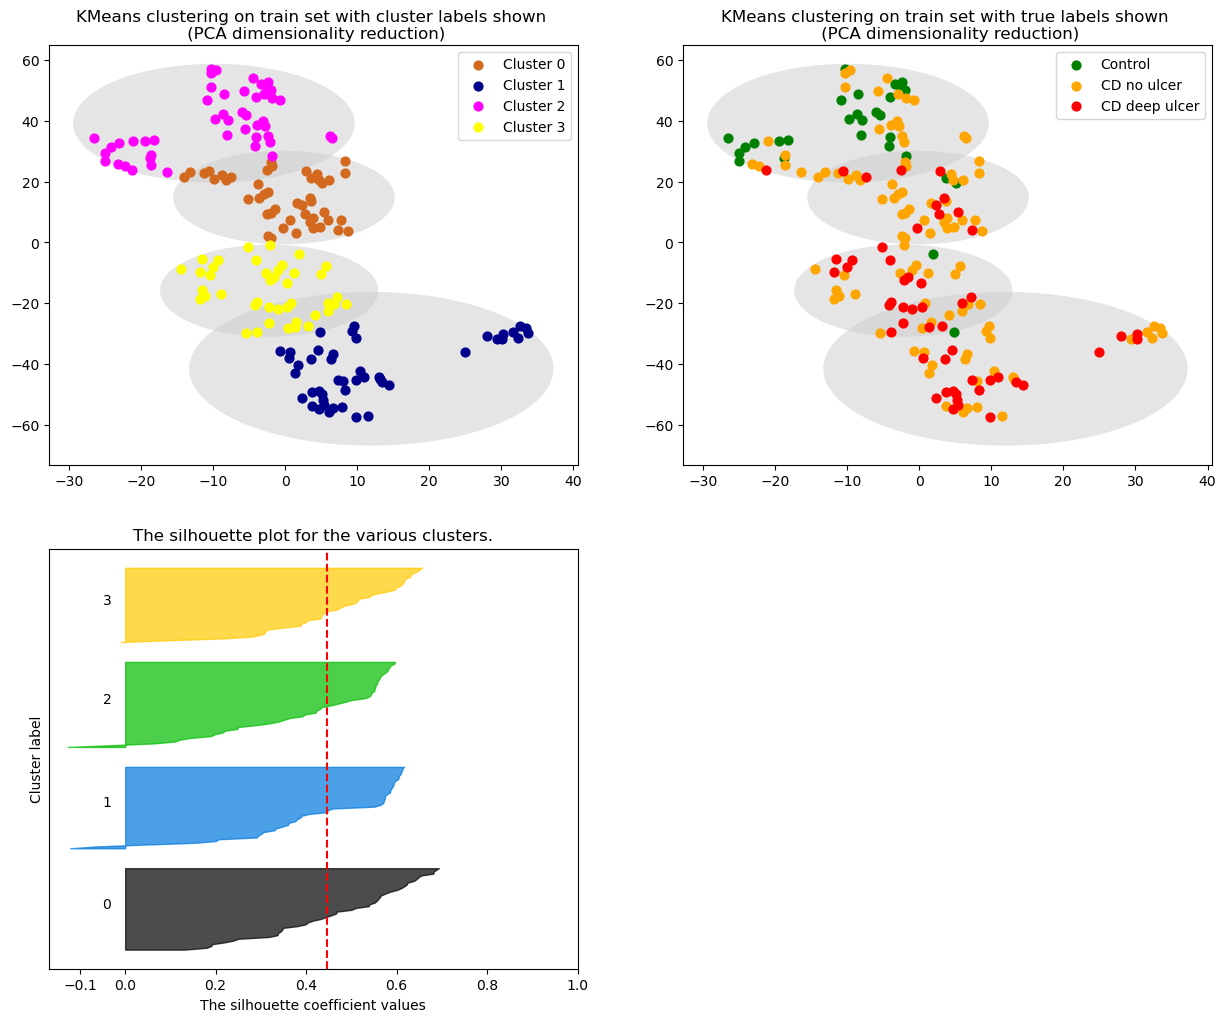

The average silhouette_score is : 0.44620553


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 20


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


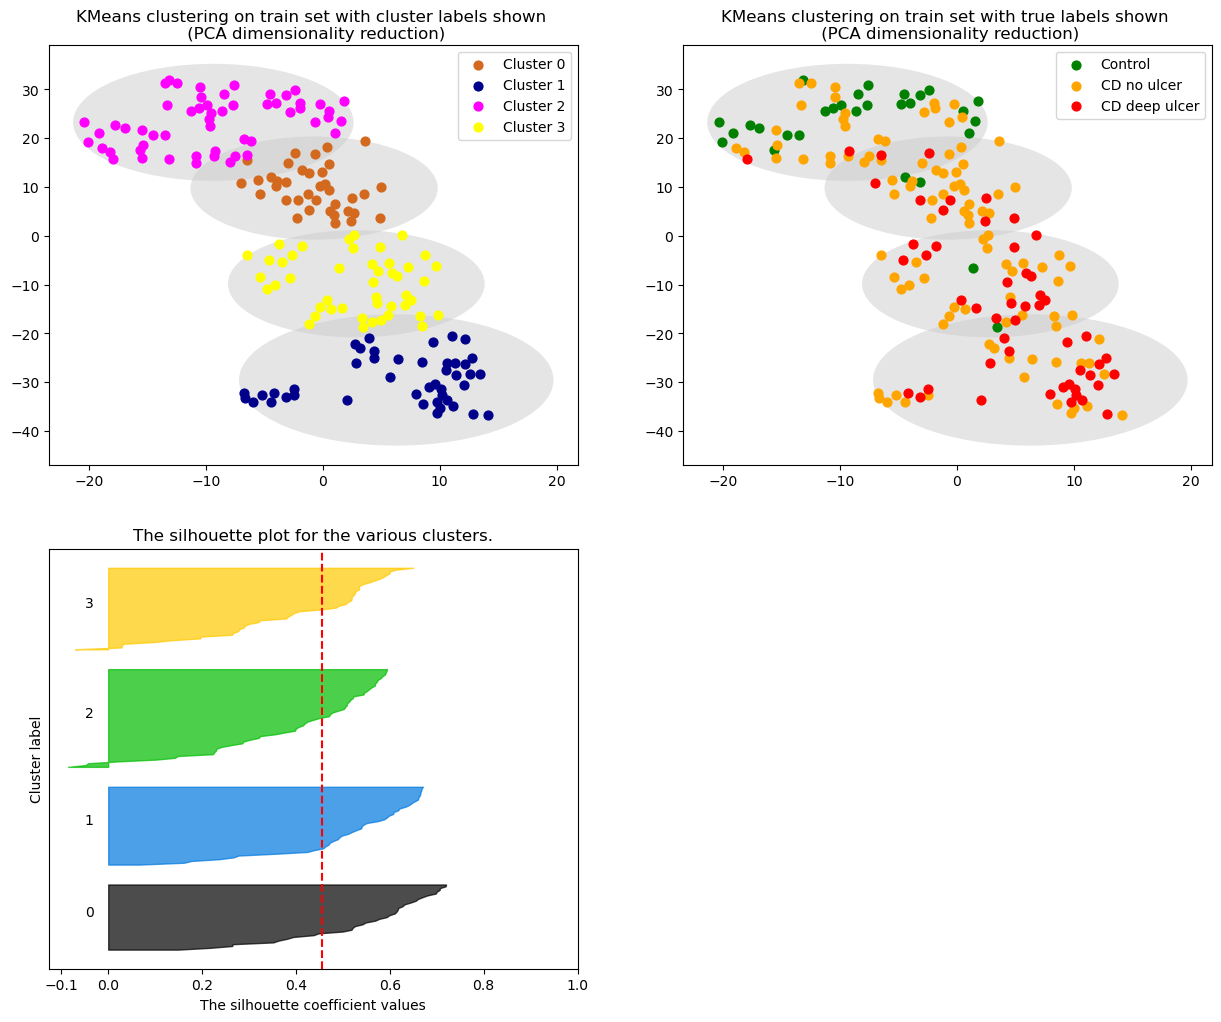

The average silhouette_score is : 0.45496726


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 50


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


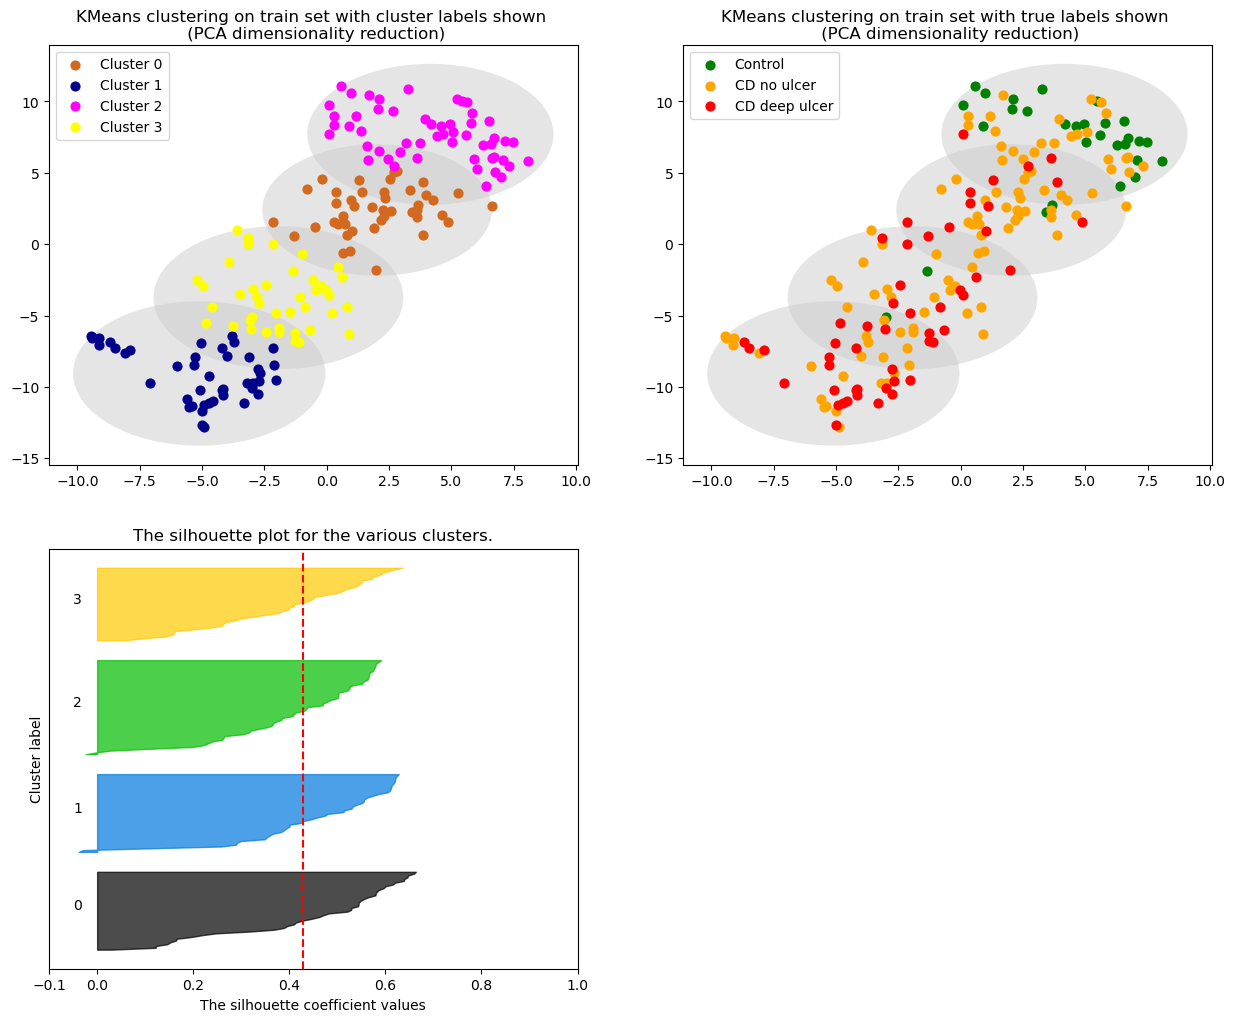

The average silhouette_score is : 0.42822543


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 70


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


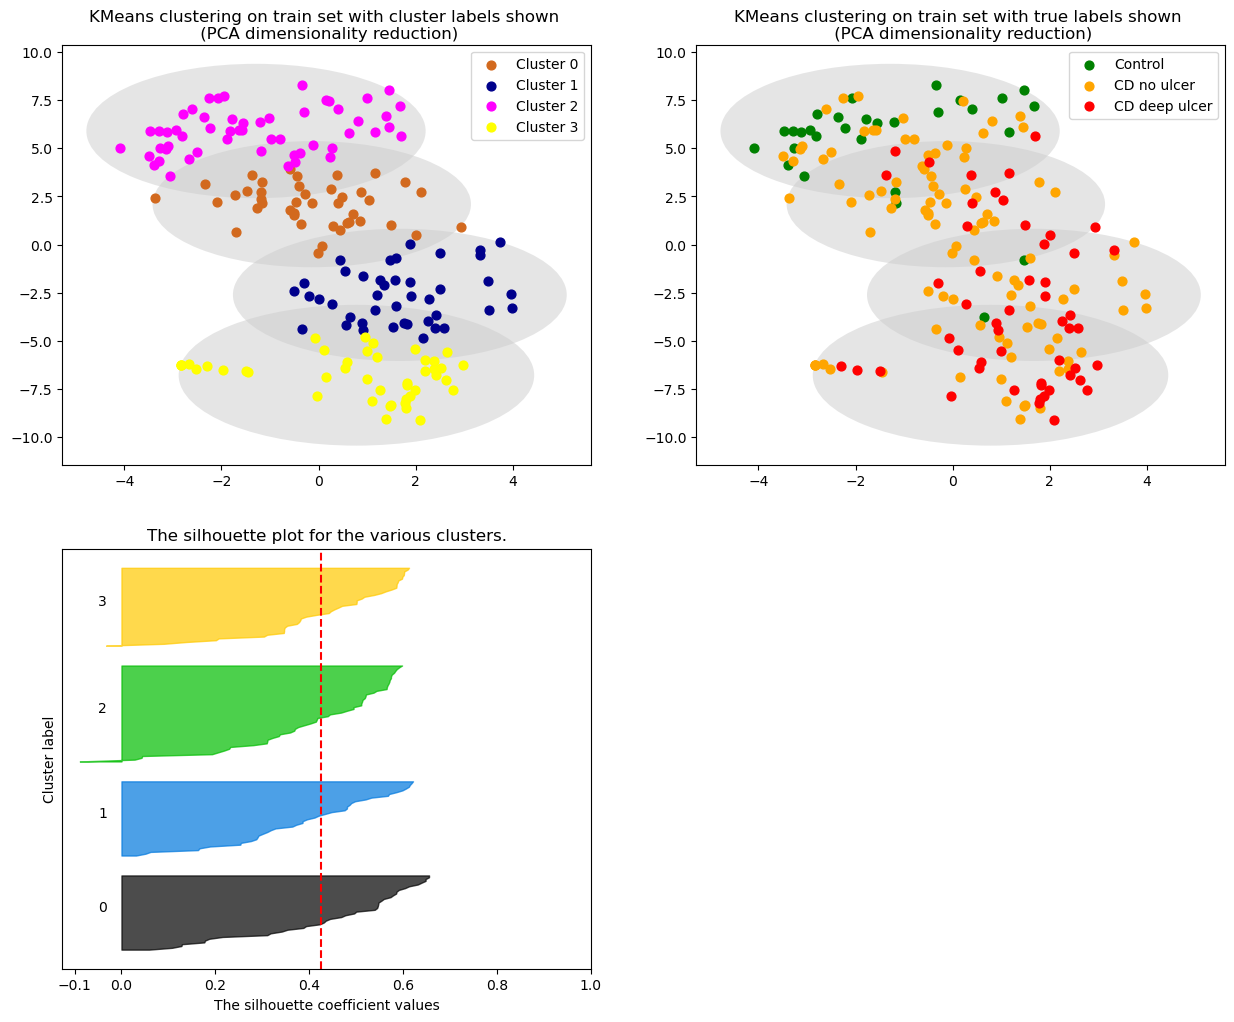

The average silhouette_score is : 0.4244394


In [199]:
perplexities = [10, 20, 50, 70]

for perplexity in perplexities:
    kmeans_pca, X_train_pca, X_test_pca, k_labels_train_pca, k_labels_test_pca, centers_pca, radii_pca = train_kmeans(full_pca_dataset, perplexity)
    print("Perplexity =",perplexity)
#     print(k_labels_train_pca)
    plot_kmeans(X_train_pca, train_disease_labels, k_labels_train_pca, centers_pca, radii_pca, "PCA", test_set=False, plot_sil=True)

### Testing

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 24


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


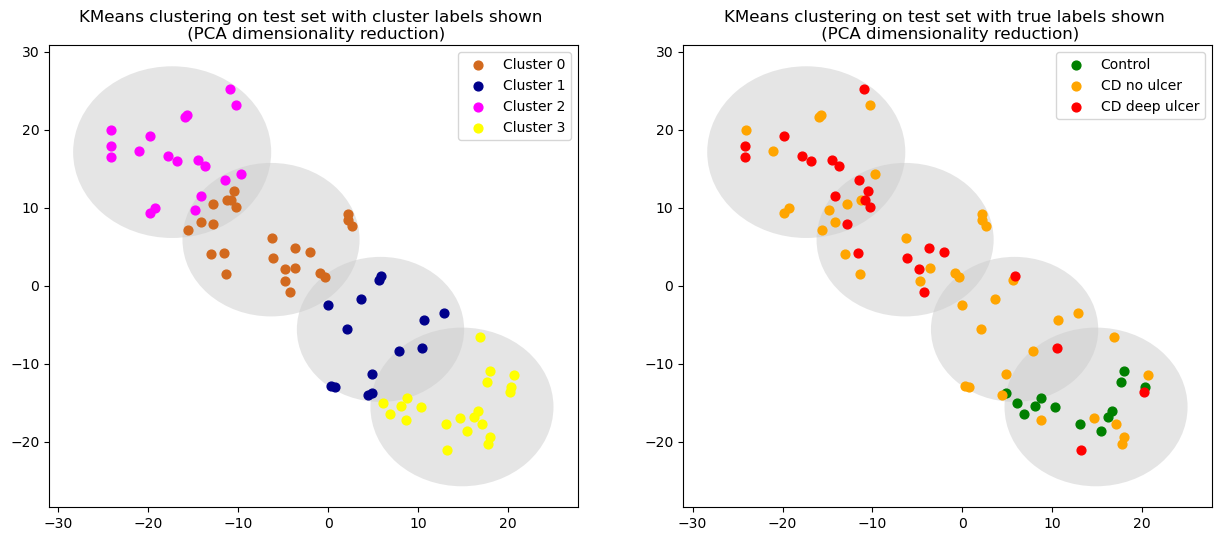

In [200]:
# plot with chosen tsne
perplexity = 24
kmeans_pca, X_train_pca, X_test_pca, k_labels_train_pca, k_labels_test_pca, centers_pca, radii_pca = train_kmeans(full_pca_dataset, perplexity)
print("Perplexity =",perplexity)
plot_kmeans(X_test_pca, test_disease_labels, k_labels_test_pca, centers_pca, radii_pca, "PCA", test_set=True)

### Fit KMeans (Autoencoder & tSNE dimensionality reduction)

### Training

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 10


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


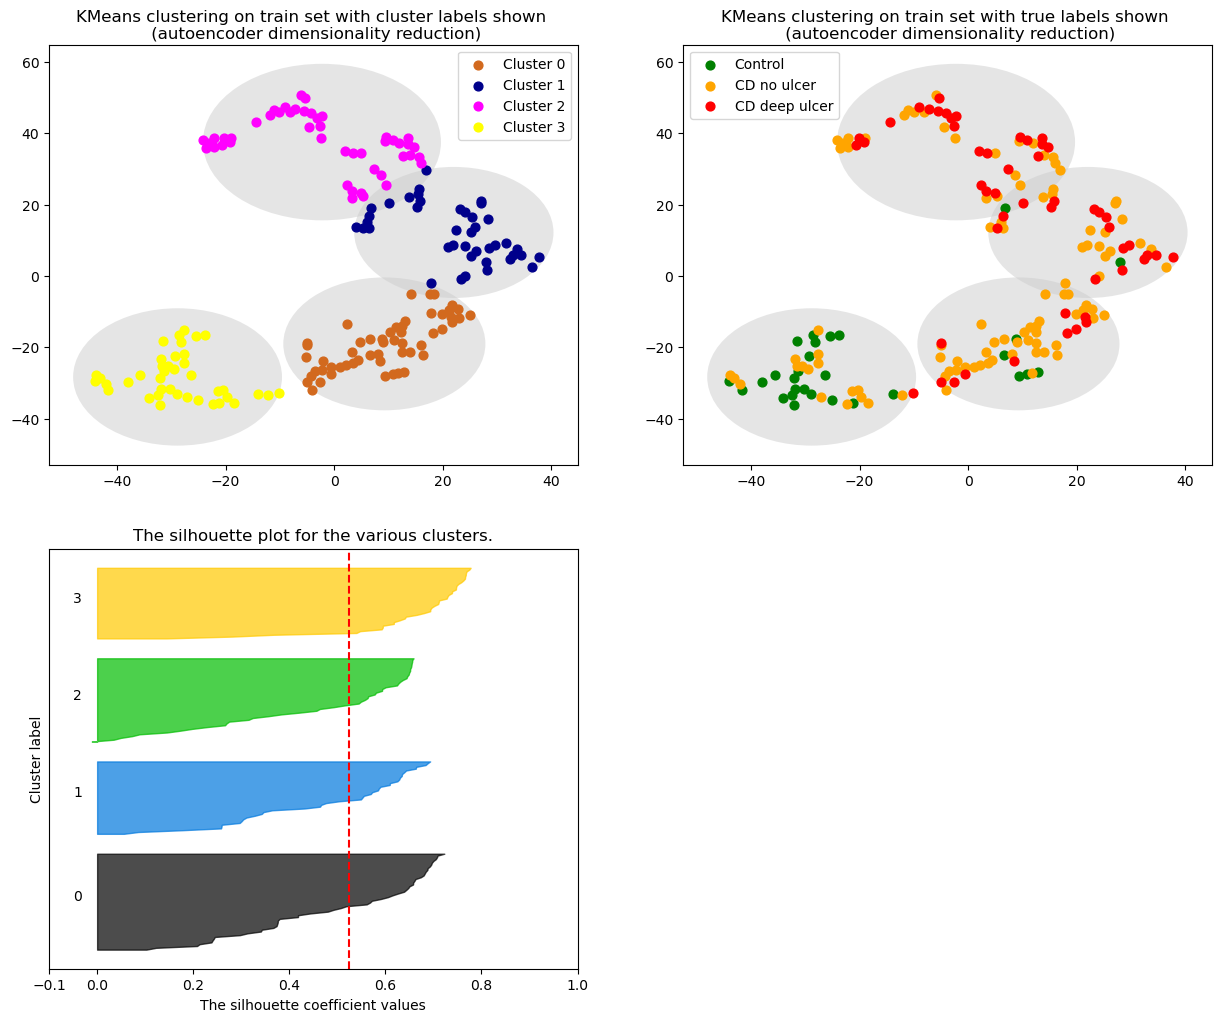

The average silhouette_score is : 0.5240724


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 20


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


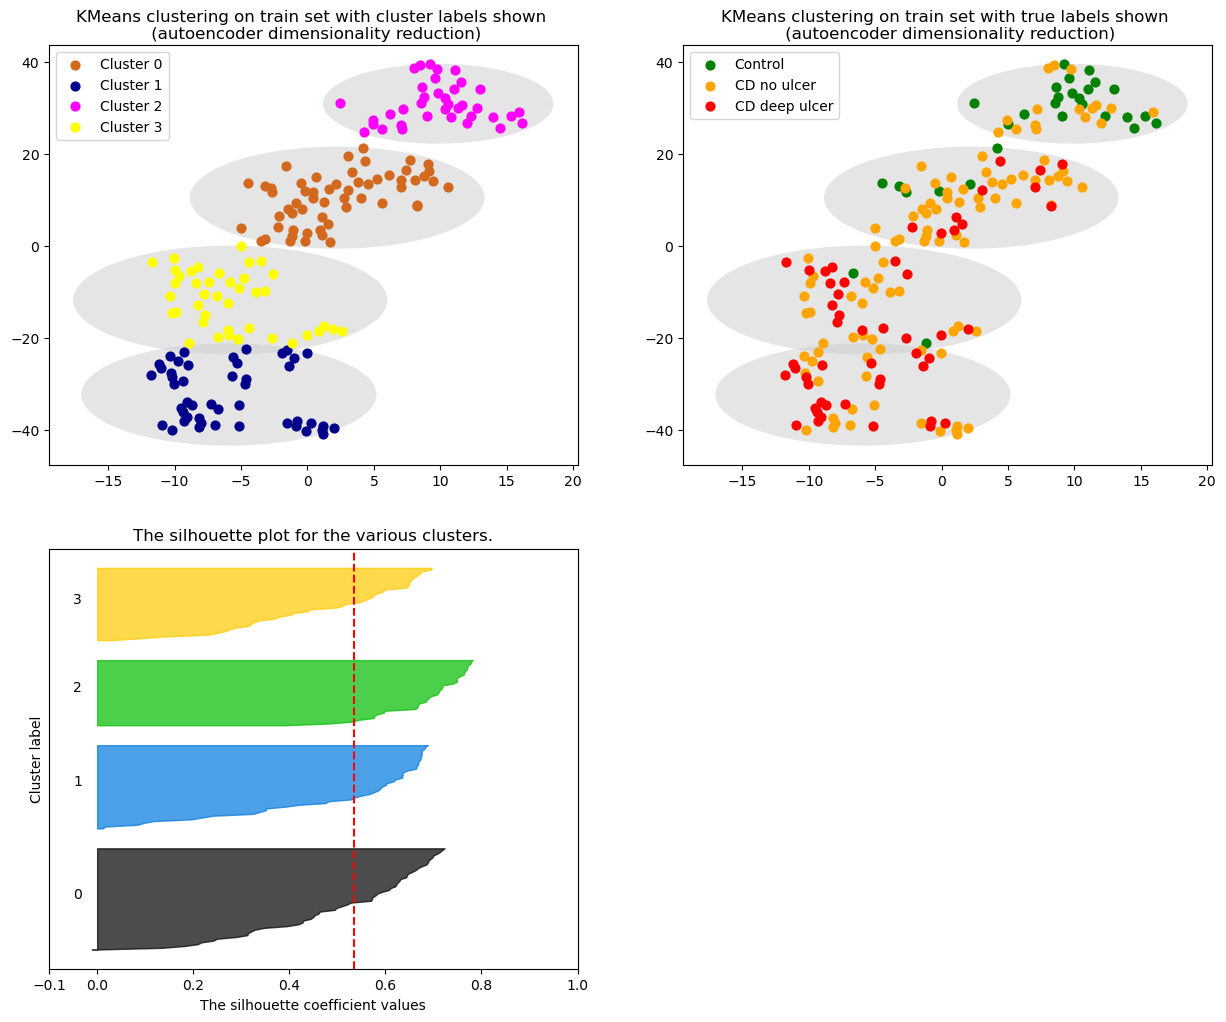

The average silhouette_score is : 0.5354044


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 50


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


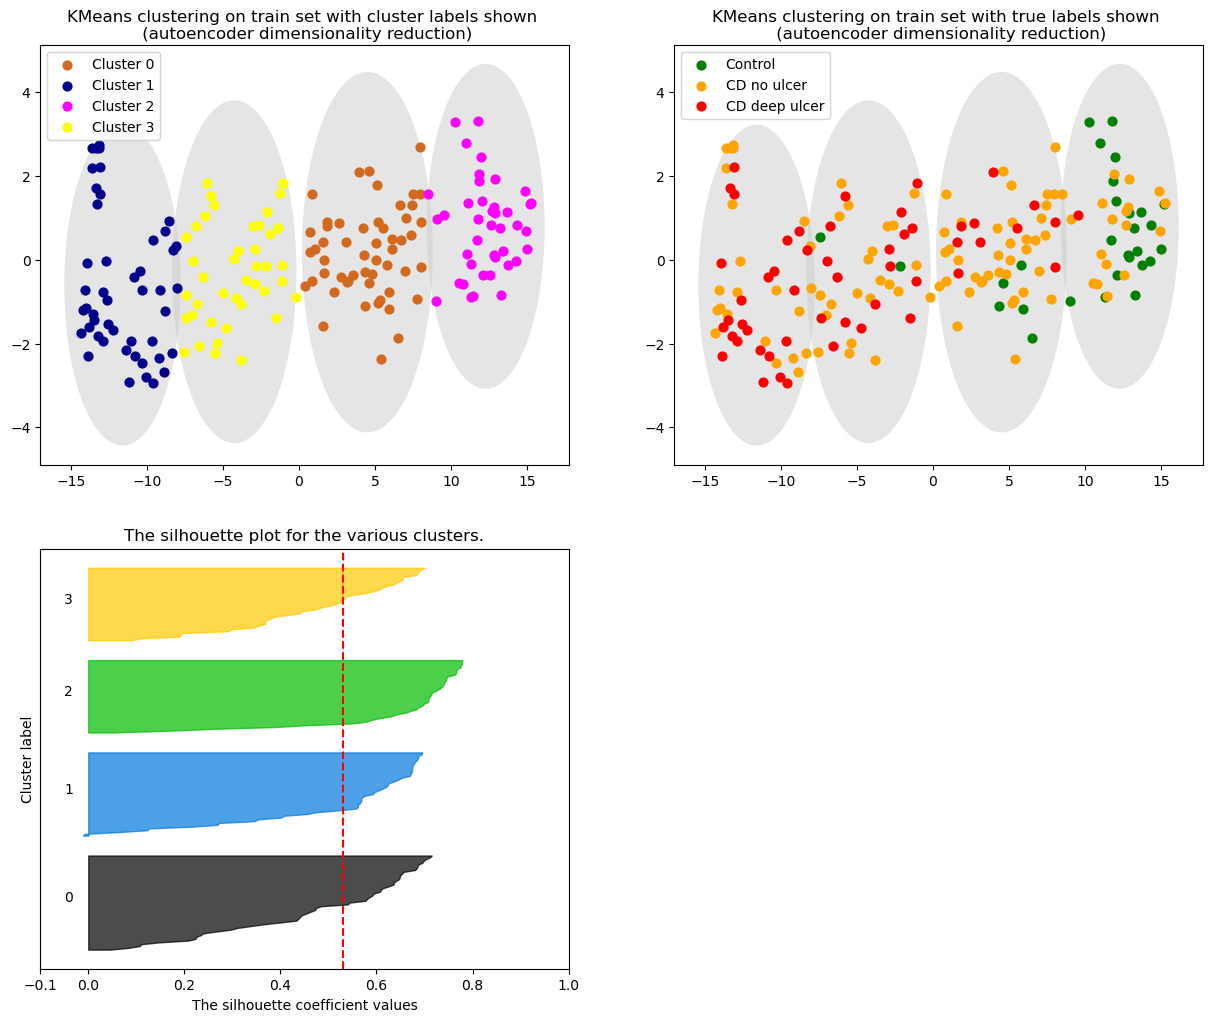

The average silhouette_score is : 0.52930796


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 70


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


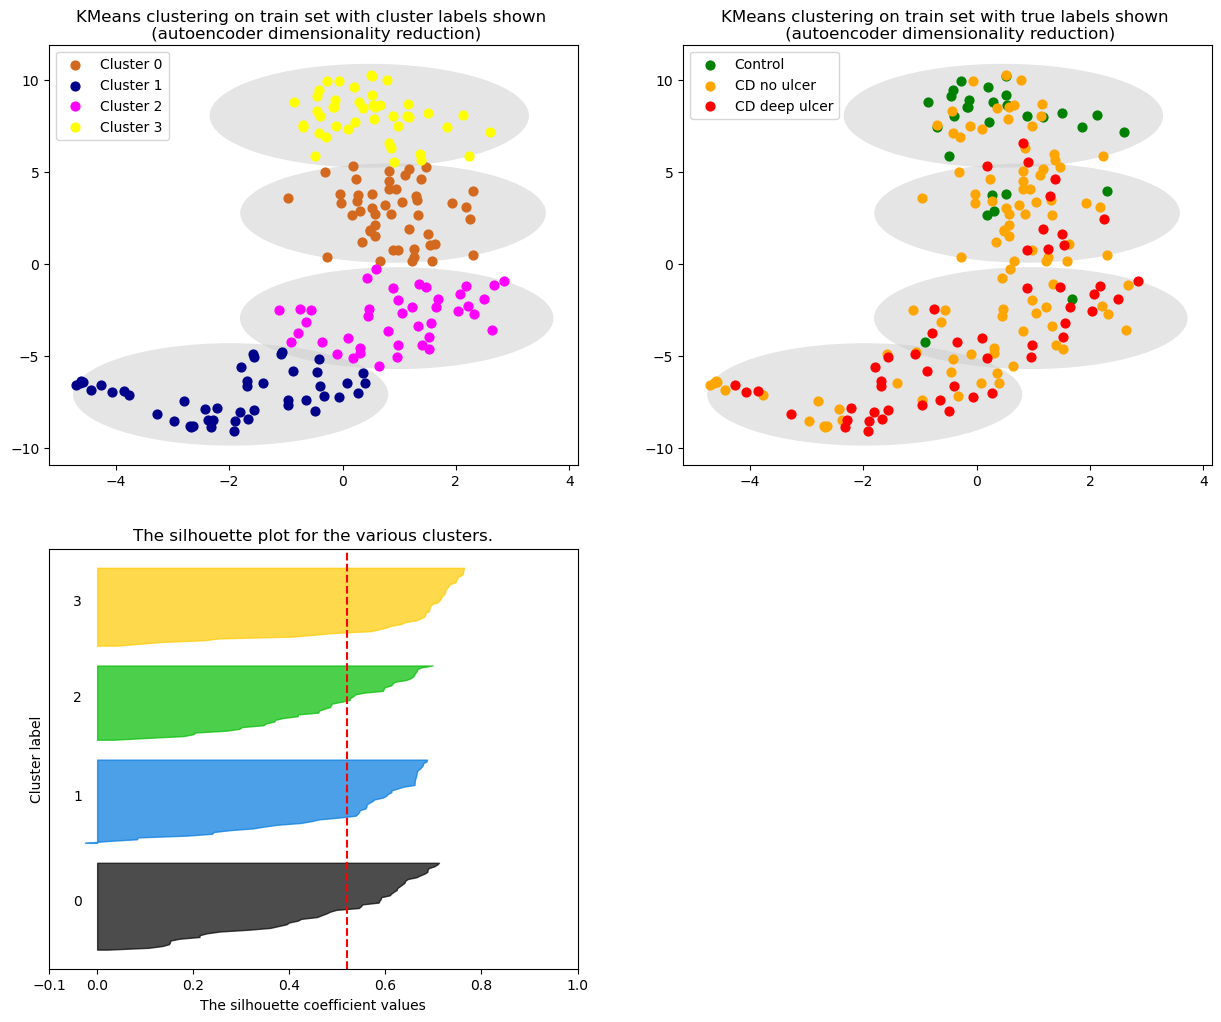

The average silhouette_score is : 0.5191784


In [201]:
perplexities = [10, 20, 50, 70]

for perplexity in perplexities:
    kmeans_ae, X_train_ae, X_test_ae, k_labels_train_ae, k_labels_test_ae, centers_ae, radii_ae = train_kmeans(full_ae_dataset, perplexity)
    print("Perplexity =",perplexity)
    plot_kmeans(X_train_ae, train_disease_labels, k_labels_train_ae, centers_ae, radii_ae, "autoencoder", test_set=False, plot_sil=True)

### Testing

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Perplexity = 24


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3345946104.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Y[label_set==i, 0], Y[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


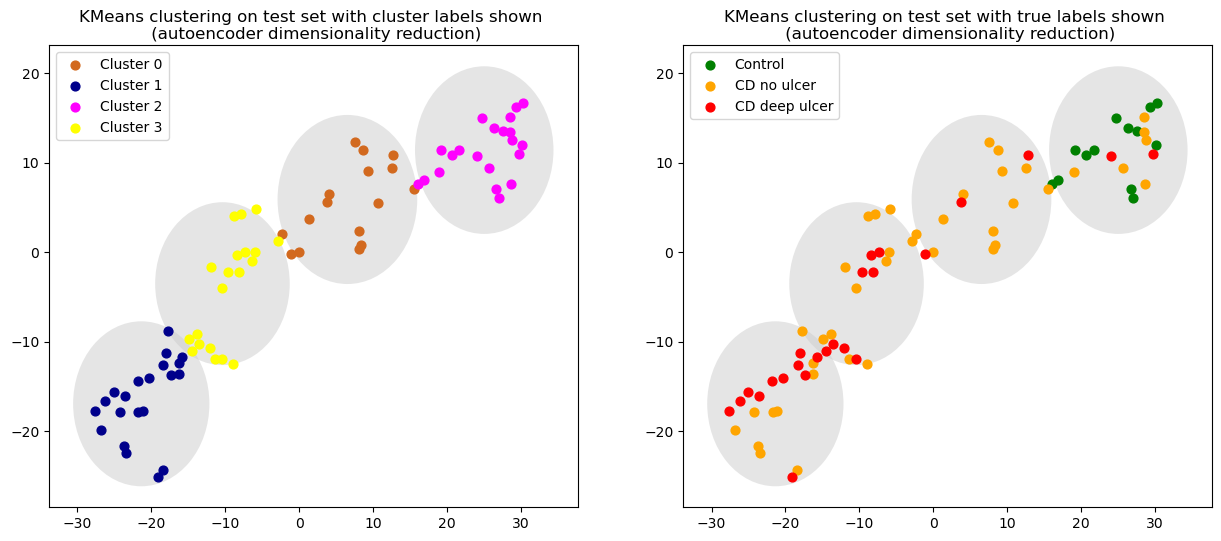

In [202]:
# plot with chosen tsne
perplexity = 24
kmeans_ae, X_train_ae, X_test_ae, k_labels_train_ae, k_labels_test_ae, centers_ae, radii_ae = train_kmeans(full_ae_dataset, perplexity)
print("Perplexity =",perplexity)
plot_kmeans(X_test_ae, test_disease_labels, k_labels_test_ae, centers_ae, radii_ae, "autoencoder", test_set=True)

## Process KMeans models

In [203]:
def pair_repeat(dup, cls_assignments, num_c, amounts):
    all_clusters = np.arange(num_c)
    # replace one of the duplicates with max of remaining clusters
    replace_class = np.where(cls_assignments == dup[0])[0][0]
    rem_cluster_a, rem_cluster_b = np.setdiff1d(all_clusters,cls_assignments)
    # rem_cluster_b
    if amounts[replace_class][rem_cluster_a] > amounts[replace_class][rem_cluster_b]:
        cls_assignments[replace_class] = rem_cluster_a
    else:
        cls_assignments[replace_class] = rem_cluster_b
        
    return cls_assignments

def handle_duplicates(cls_assignments, dup, c, num_c, amounts):
#     print("c:",c)
    if len(c) != 1:
        
        cls_assignments = pair_repeat(dup, cls_assignments, num_c, amounts)
    else: # 3 repeats of same thing
        # reassign class least associated to next most associated cluster
        given_cluster = dup[0]
        cls_least = np.argmin(amounts[:,given_cluster])
#         print(cls_least)
        class_amounts = amounts[cls_least,:]
        class_amounts[given_cluster] = -1
        next_cluster = np.argmax(class_amounts)
        cls_assignments[cls_least] = next_cluster
#         print("intermediate assignments",cls_assignments)
        
        # handle other duplicate pair
        u, c = np.unique(cls_assignments, return_counts=True)
        dup = u[c > 1]
        cls_assignments = pair_repeat(dup, cls_assignments, num_c, amounts)

    return cls_assignments

In [204]:

    
def process_clusters(amounts, X_train, num_c):
    all_clusters = np.arange(num_c)

    
    cls_assignments = np.argmax(amounts, axis=1) # assigned to class 0, 1, 2
    print("initial cls assignments:",cls_assignments)
    
    # check for and handle duplicates
    u, c = np.unique(cls_assignments, return_counts=True)
    dup = u[c > 1]
#     print("dup:",dup[0])
    if len(dup) > 0:
        cls_assignments = handle_duplicates(cls_assignments, dup, c, num_c, amounts)
        
            
    class_assignment_amounts = np.max(amounts, axis=1) 
    
    assignments = [None] * 3
    
    assigned = 0
    while assigned < num_c - 1:
        curr_max_class = np.argmax(class_assignment_amounts)
        assigned_cluster = cls_assignments[curr_max_class]
        if assignments[curr_max_class] is None:
            assignments[curr_max_class] = [assigned_cluster]
        else:
            assignments[curr_max_class].append(assigned_cluster)
        class_assignment_amounts[curr_max_class] = -1
        assigned += 1

    # Assign remaining cluster
    
    rem_cluster = np.setdiff1d(all_clusters,cls_assignments)[0]
    
    rem_cls_assignment = np.argmax(amounts[:,rem_cluster], axis=0)
    assignments[rem_cls_assignment].append(rem_cluster)
    couple = assignments[rem_cls_assignment]
    # clusters assigned to disease class 0, 1, 2 (control, CD_no_ulcer, CD_deep_ulcer)
    
#     print(assignments)
#     print(couple)
    return assignments, couple

In [205]:
def get_class_from_label(label, couple, assignments):
    if label in couple:
        search_term = couple
    else:
        search_term = [label]
    try:
        cls = assignments.index(search_term)
    except:
        return None
    return cls


In [206]:
def get_final_clusters(assignments, couple, labels):
    test_set_clusters = []
    for label in labels:
        cls = get_class_from_label(label, couple, assignments)
        test_set_clusters.append(cls)

    test_set_clusters = np.array(test_set_clusters)
    return test_set_clusters

In [207]:
# centers = kmeans.cluster_centers_
# centers

In [208]:
num_c = 4

In [209]:
def get_count_matrix_km(kmeans, X_train, train_disease_labels):

    
    # make matrix to record number of each class in each cluster
    amounts = np.zeros((3, num_c))
    
    
    classes = ["control", "CD_no_ulcer", "CD_deep_ulcer"]
    centers = kmeans.cluster_centers_
    for c, cls in enumerate(classes):
        for pt in X_train[train_disease_labels==c]:
            pt = pt.reshape(1,-1)
            distances = cdist(centers, pt, 'euclidean')
            closest_cluster = np.argmin(distances)
            amounts[c][closest_cluster] += 1
    

#     print(amounts)
    #                cluster 0, cluster 1, cluster 2, cluster 3
    # control 
    # CD no ulcer
    # CD deep ulcer
    
    return amounts

In [210]:
# get_count_matrix_km(kmeans, X_train, train_disease_labels)

### Apply resulting models to test sets

In [211]:
centers_pca

array([[ -6.371068 ,   5.9056115],
       [  5.8009024,  -5.5992637],
       [-17.361135 ,  17.134462 ],
       [ 14.8569355, -15.547556 ]], dtype=float32)

In [212]:
km_labels_list = [k_labels_test_ae, k_labels_test_pca]
km_models_list = [kmeans_ae, kmeans_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]
centers_list = [centers_ae, centers_pca]
radii_list = [radii_ae, radii_pca]


In [213]:
# X_test_ae

initial cls assignments: [2 0 1]
initial cls assignments: [3 1 2]


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\3240046153.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)


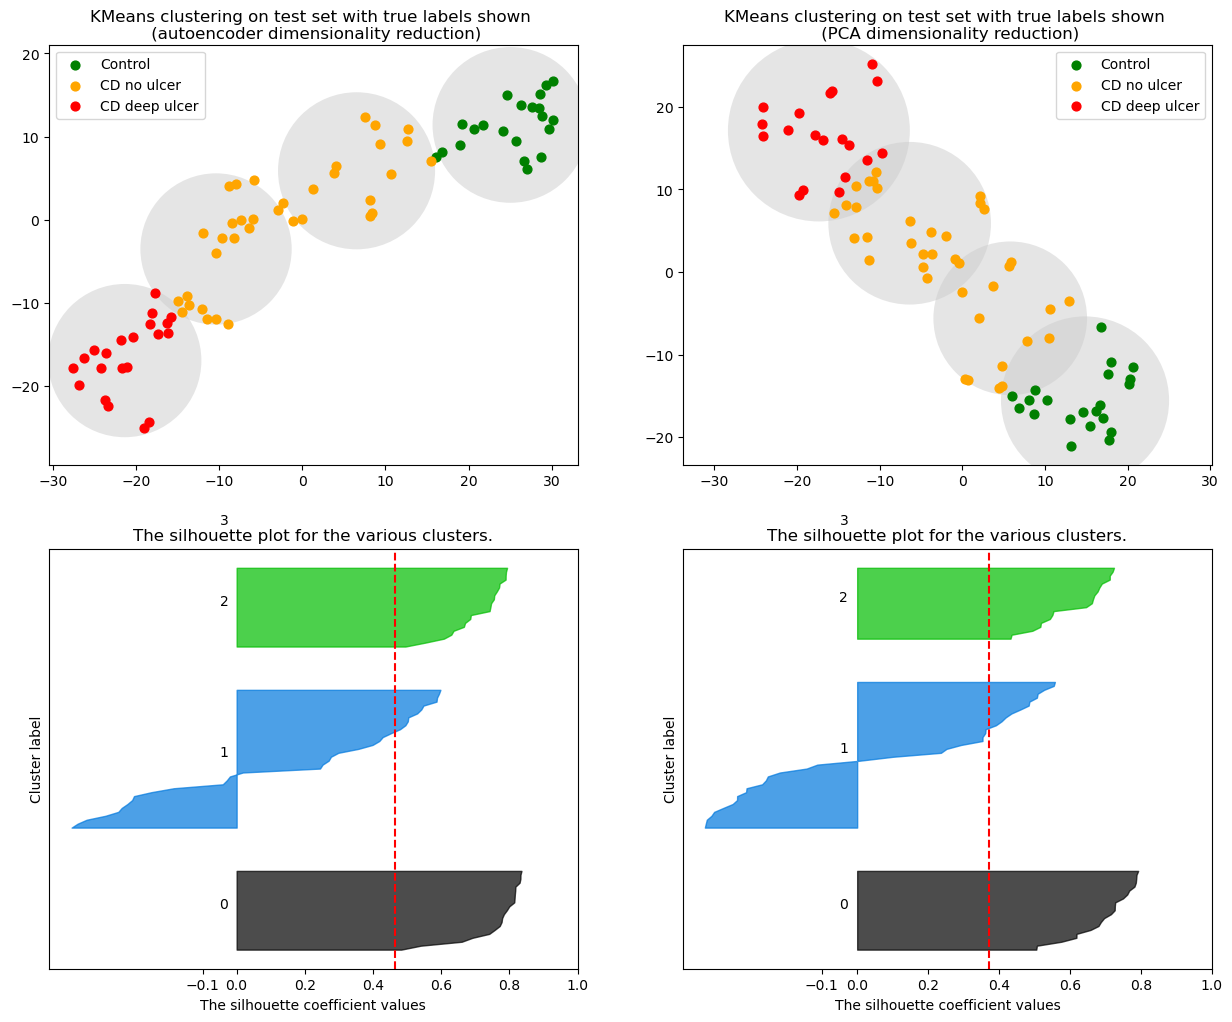

Autoencoder: average silhouette score = 0.46537134
PCA: average silhouette score = 0.37121758


In [214]:
def plot_final_km_models(labels_list, models_list, train_set_list, test_set_list, centers_list, radii_list, num_c):
#         left = -8
#         right = 8
#         ax.set_xlim(left, right)
#         ax.set_ylim(left, right)
        
        
#         if i==0:
#             num_clusters = num_c
#             cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
#             colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
#             ax.set_title("GMM soft clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
#                          wrap=True)
#         else:
#     fig, ax = plt.subplots()
    (fig, subplots) = plt.subplots(2, 2, figsize=(15,12))
    reduction = ["autoencoder", "PCA"]
    final_clusters_lst = []
    for i in range(len(models_list)):
#         print(i)
        ax = subplots[0][i]
        km = models_list[i]
        km_labels = labels_list[i]
        X_train = train_set_list[i]
        X_test = test_set_list[i]
        centers = centers_list[i]
        radii = radii_list[i]
        amounts = get_count_matrix_km(km, X_train, train_disease_labels)
        assignments, couple = process_clusters(amounts, X_train, num_c)
        test_set_clusters = get_final_clusters(assignments, couple, km_labels)
#         print("gmmlabels:",gmm_labels)
#         print("tsclusters:",test_set_clusters)
#         print("asgn:",assignments)
        final_clusters_lst.append(test_set_clusters)




        reduc = reduction[i]
        num_clusters = 3
        cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
        colours = ["green", "orange", "red"]
        ax.set_title("KMeans clustering on test set with true labels shown \n (" + reduc + " dimensionality reduction)",
                    wrap=True)

        for i in range(num_clusters):
            ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

        ax.axis('equal')


        for c, r in zip(centers, radii):
            ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
            
        ax.legend()

    s_avgs = []
    for j in range(2):
        ax = subplots[1][j]
        X_test = test_set_list[j]
        test_clusters = final_clusters_lst[j]

        silhouette_avg, sample_silhouette_values = compute_silh_scores(X_test, test_clusters)
        s_avgs.append(silhouette_avg)
        plot_silhouette(num_c, test_clusters, sample_silhouette_values, silhouette_avg, ax)

    plt.show()

    print("Autoencoder: average silhouette score =",s_avgs[0])
    print("PCA: average silhouette score =",s_avgs[1])

    return final_clusters_lst
        
final_clusters_ae, final_clusters_pca = plot_final_km_models(km_labels_list, km_models_list, train_set_list, test_set_list, centers_list, radii_list, num_c)

In [215]:
final_clusters_ae

array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, 2, 2,
       0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1])

## Gaussian Mixture Models

In [216]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

from matplotlib.patches import Ellipse
from sklearn import mixture

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, true_labels, reduction, num_c=3, test=False, plot_sil=False):
    
    
    num_rows = 2 if plot_sil else 1
    dim_h = 12 if plot_sil else 6
    dim_w = 15 if plot_sil else 15
    (fig, subplots) = plt.subplots(num_rows, 2, figsize=(dim_w, dim_h))
    

    gmm_labels = gmm.predict(X)
#     (fig, subplots) = plt.subplots(1, 2, figsize=(15, 6))
#     ax = ax or plt.gca()
    labels = [gmm_labels, true_labels]
    num_clusters = 3
    dset = "test" if test else "train"
    for i, label_set in enumerate(labels):
        ax = subplots[0][i] if plot_sil else subplots[i]
#         left = -8
#         right = 8
#         ax.set_xlim(left, right)
#         ax.set_ylim(left, right)
        
        
        if i==0:
            num_clusters = num_c
            cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
            colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
            ax.set_title("GMM soft clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
                         wrap=True)
        else:
            num_clusters = 3
            cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
            colours = ["green", "orange", "red"]
            ax.set_title("GMM soft clustering on " + dset + " set with true labels shown \n (" + reduction + " dimensionality reduction)",
                        wrap=True)
            
        for i in range(num_clusters):
            ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

        ax.axis('equal')
        

        w_factor = 0.2 / gmm.weights_.max()
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)
        ax.legend()
        
        
    if plot_sil:
        silhouette_avg, sample_silhouette_values = compute_silh_scores(X, gmm_labels)
        plot_silhouette(num_c, gmm_labels, sample_silhouette_values, silhouette_avg, subplots[1][0])
        subplots[1][1].axis('off')
        
    
    plt.show()
    
    if plot_sil:
        print("The average silhouette_score is :",silhouette_avg)
        
    return gmm_labels

        
# def get_tsne_ds_true_labels():
#     tsne = manifold.TSNE(
#         n_components=2,
#         init="random",
#         random_state=0,
#         perplexity=24,
#         n_iter=750,
#         method='exact'
#     )
#     X = tsne.fit_transform(test_set)

In [217]:
# gmm.means_
# gmm.covariances_
# gmm.weights_

### Fit GMM with PCA dimensionality reduction

#### Training

In [218]:
num_c = 4

def fit_gmm(full_dataset, perplexity, num_c):
    gmm = mixture.GaussianMixture(n_components=num_c,covariance_type='full', random_state=42)
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_dataset)
    X_test = X[split_pt:]
    X_train = X[:split_pt]
    gmm.fit(X_train)
    
    return gmm, X_train, X_test

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 10


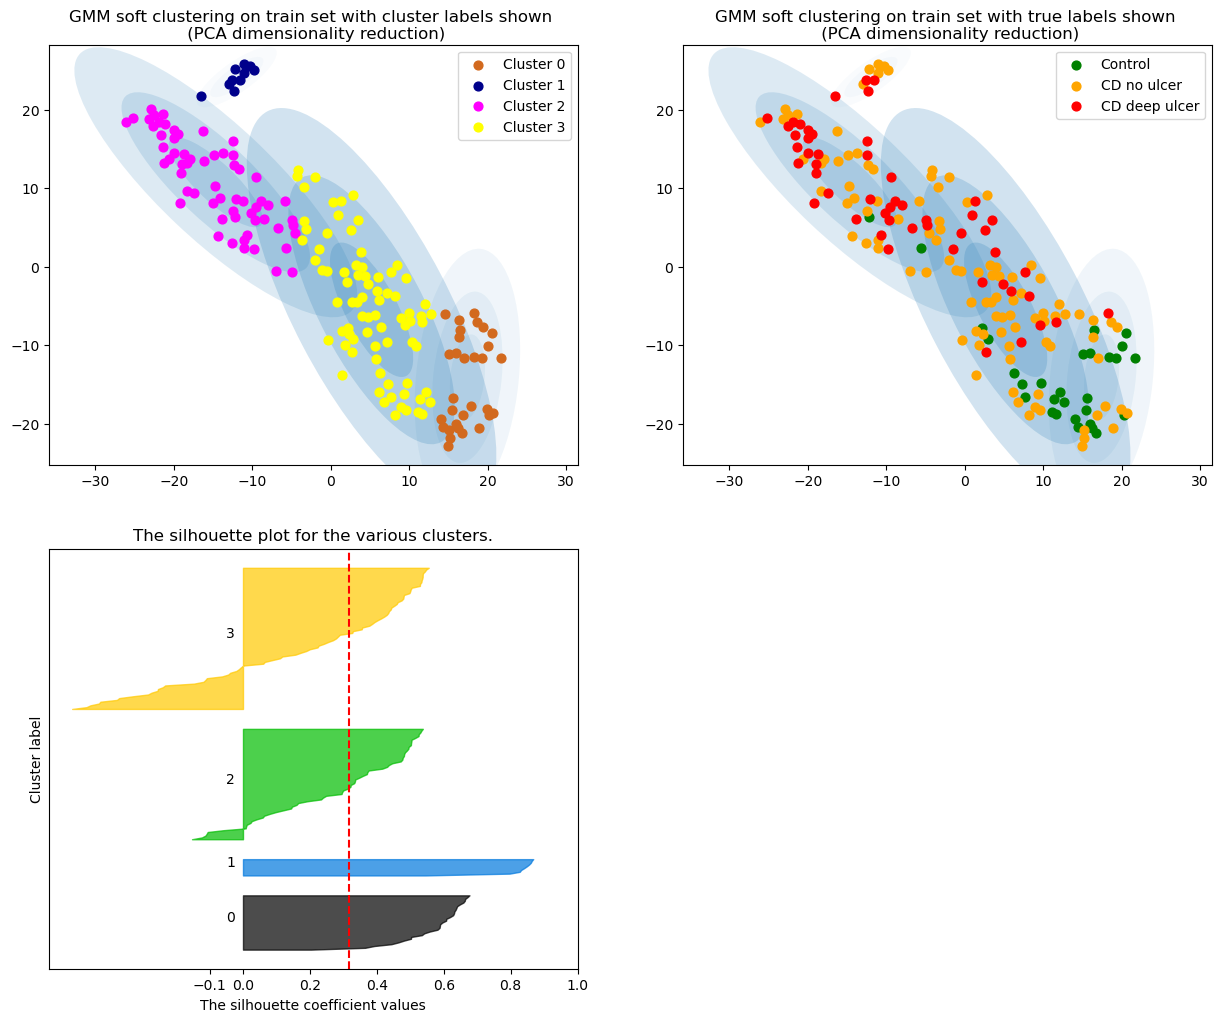

The average silhouette_score is : 0.3178249


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 20


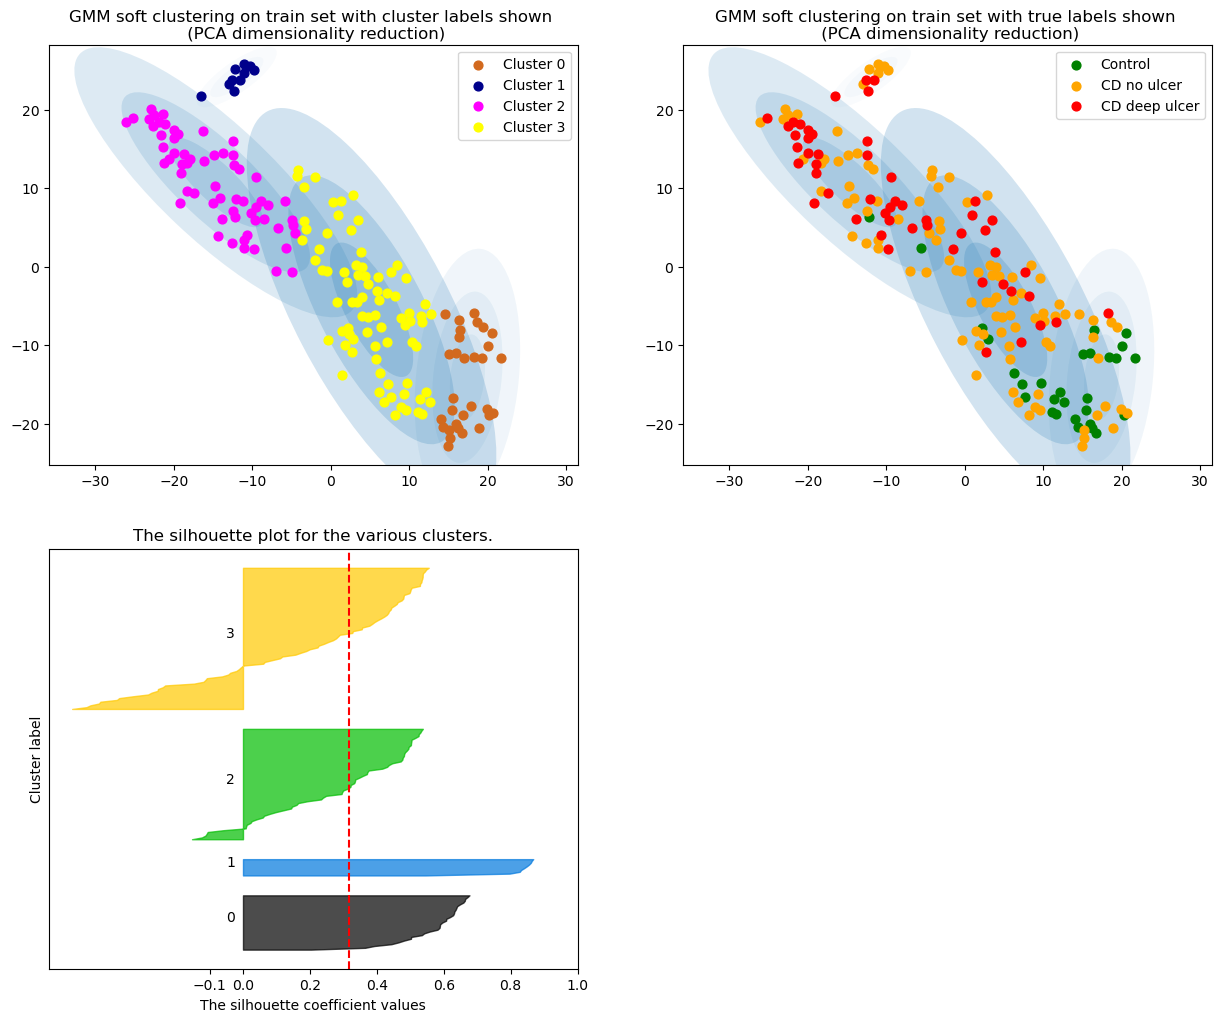

The average silhouette_score is : 0.3178249


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 50


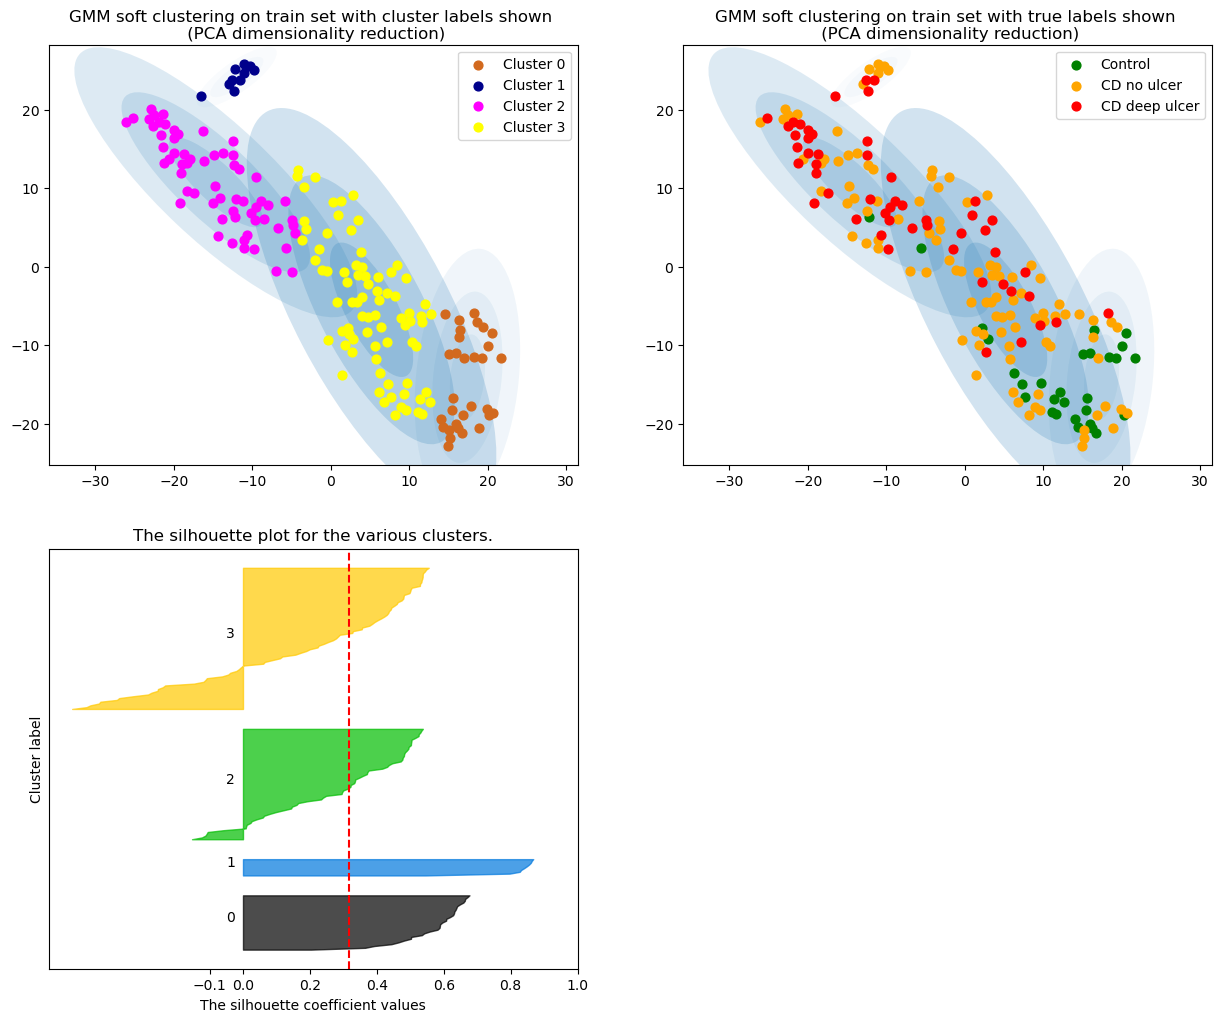

The average silhouette_score is : 0.3178249


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 70


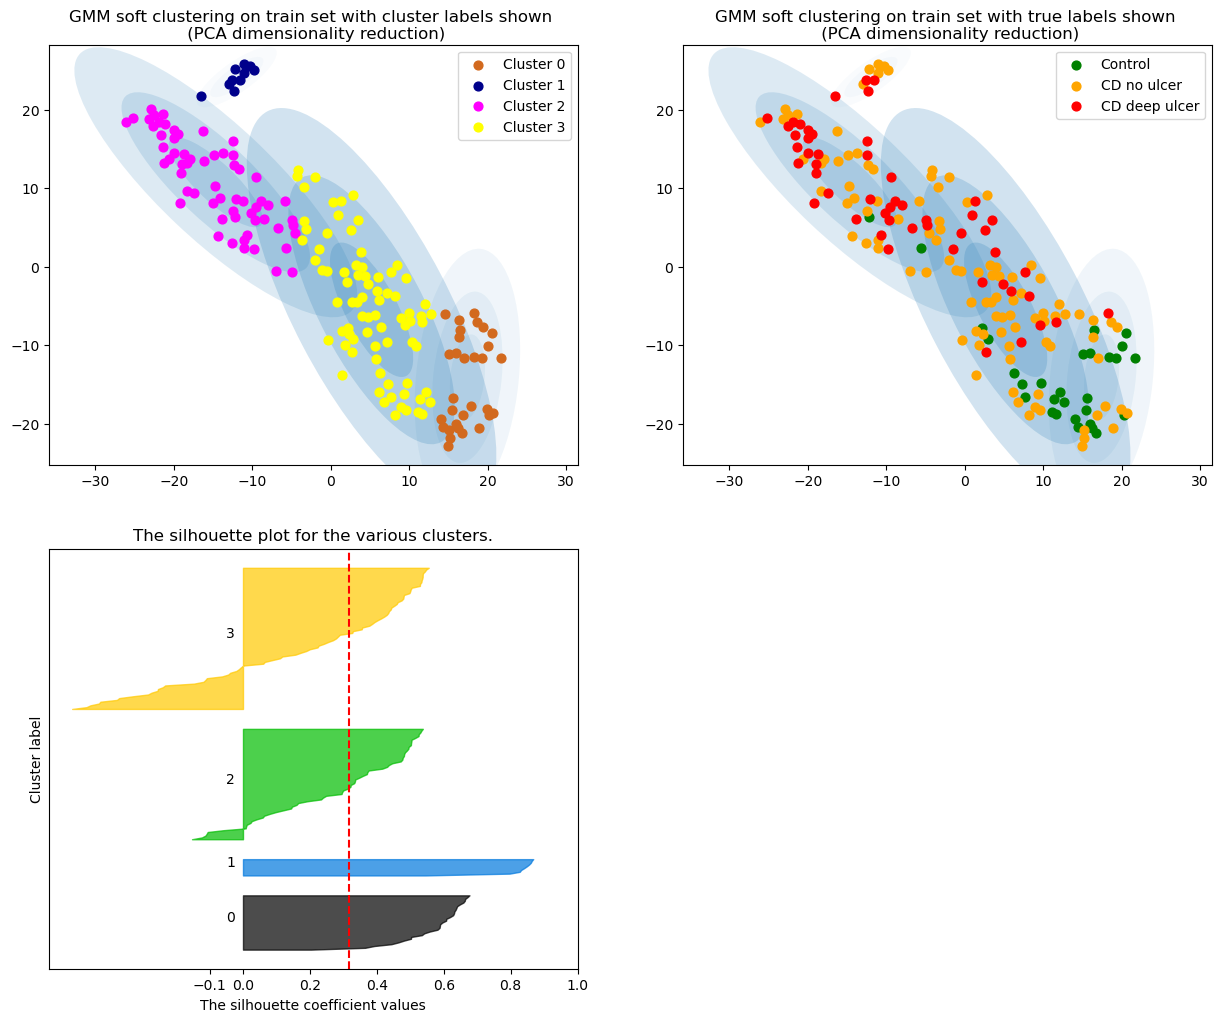

The average silhouette_score is : 0.3178249


In [219]:

perplexities = [10, 20, 50, 70]
# perplexity = 24
for perplexity in perplexities:
    gmm_pca, X_train_pca, X_test_pca = fit_gmm(full_pca_dataset, perplexity, num_c)
    print("Perplexity =",perplexity)
    plot_gmm(gmm_pca, X_train_pca, train_disease_labels, "PCA", num_c=num_c, plot_sil=True)


#### Testing

In [220]:
full_ds


,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


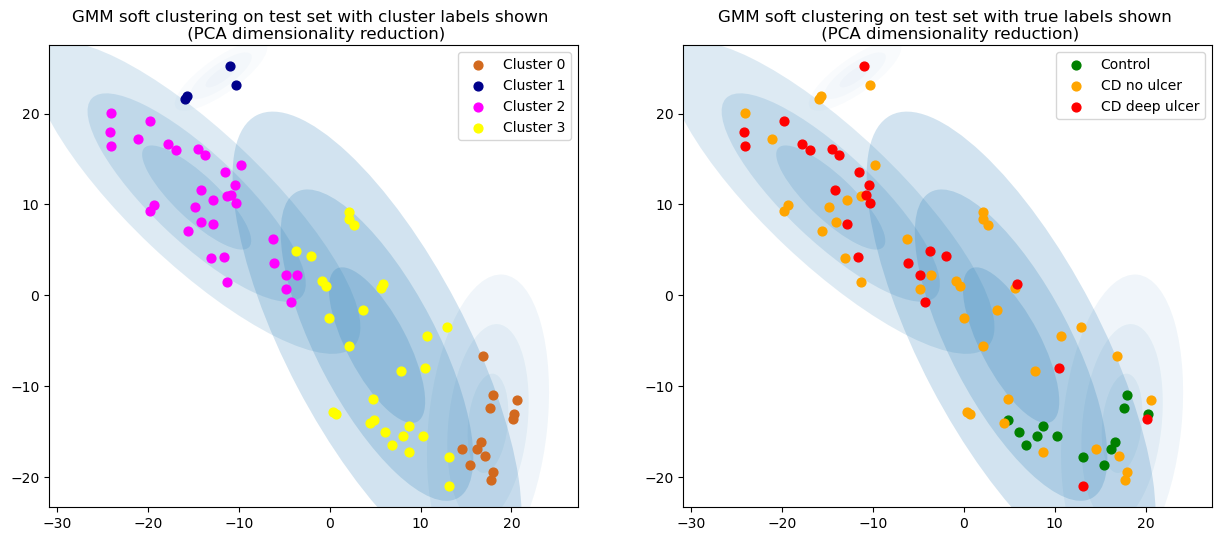

In [221]:
perplexity = 24
gmm_pca, X_train_pca, X_test_pca = fit_gmm(full_pca_dataset, perplexity, num_c)
gmm_labels_pca = plot_gmm(gmm_pca, X_test_pca, test_disease_labels, "PCA", num_c=num_c, test=True)


### Fit GMM with autoencoder dimensionality reduction

#### Training

In [222]:
# X_train_ae

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 10


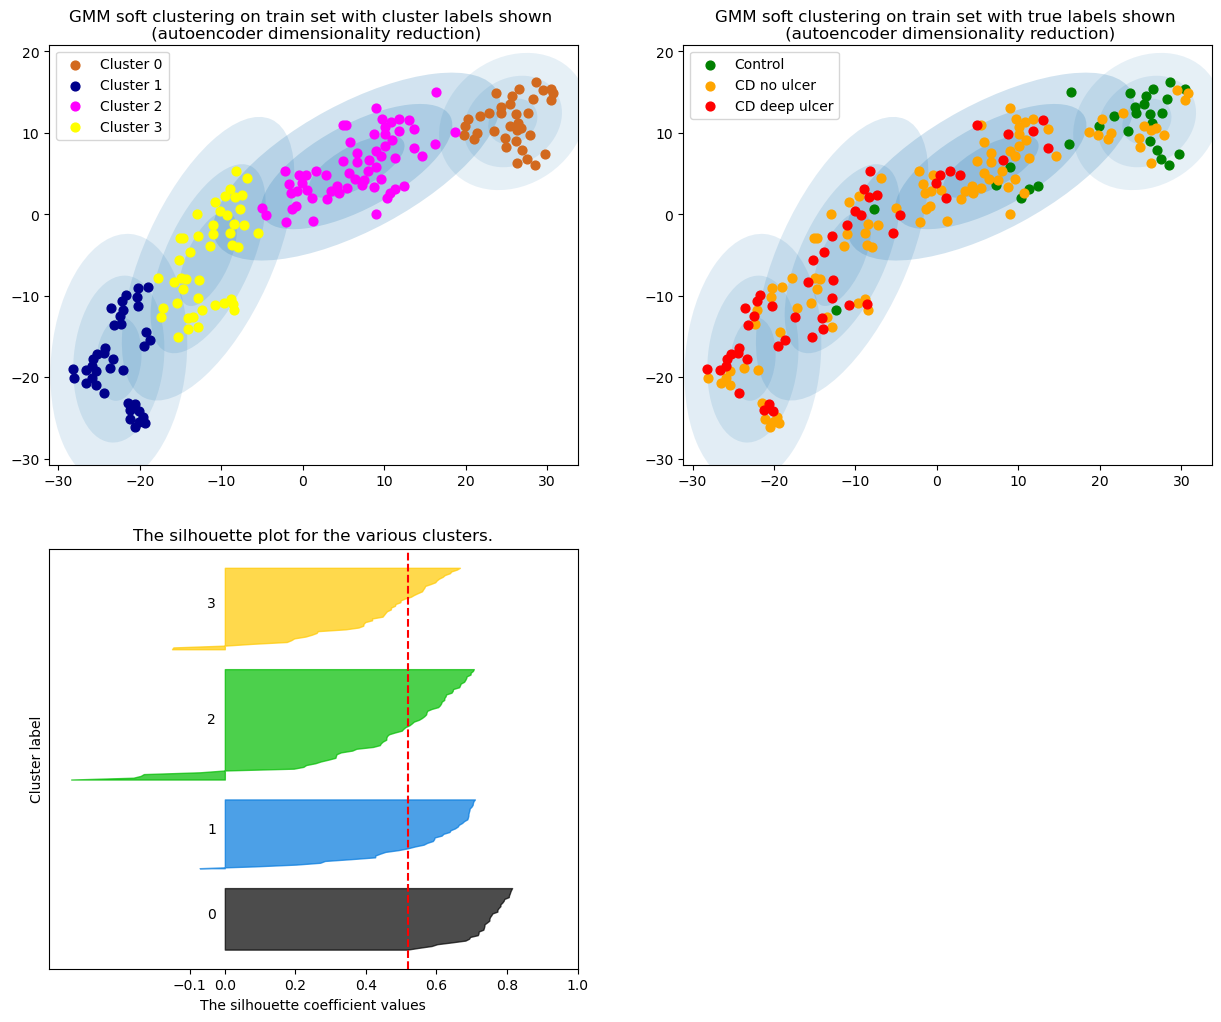

The average silhouette_score is : 0.51898056


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 20


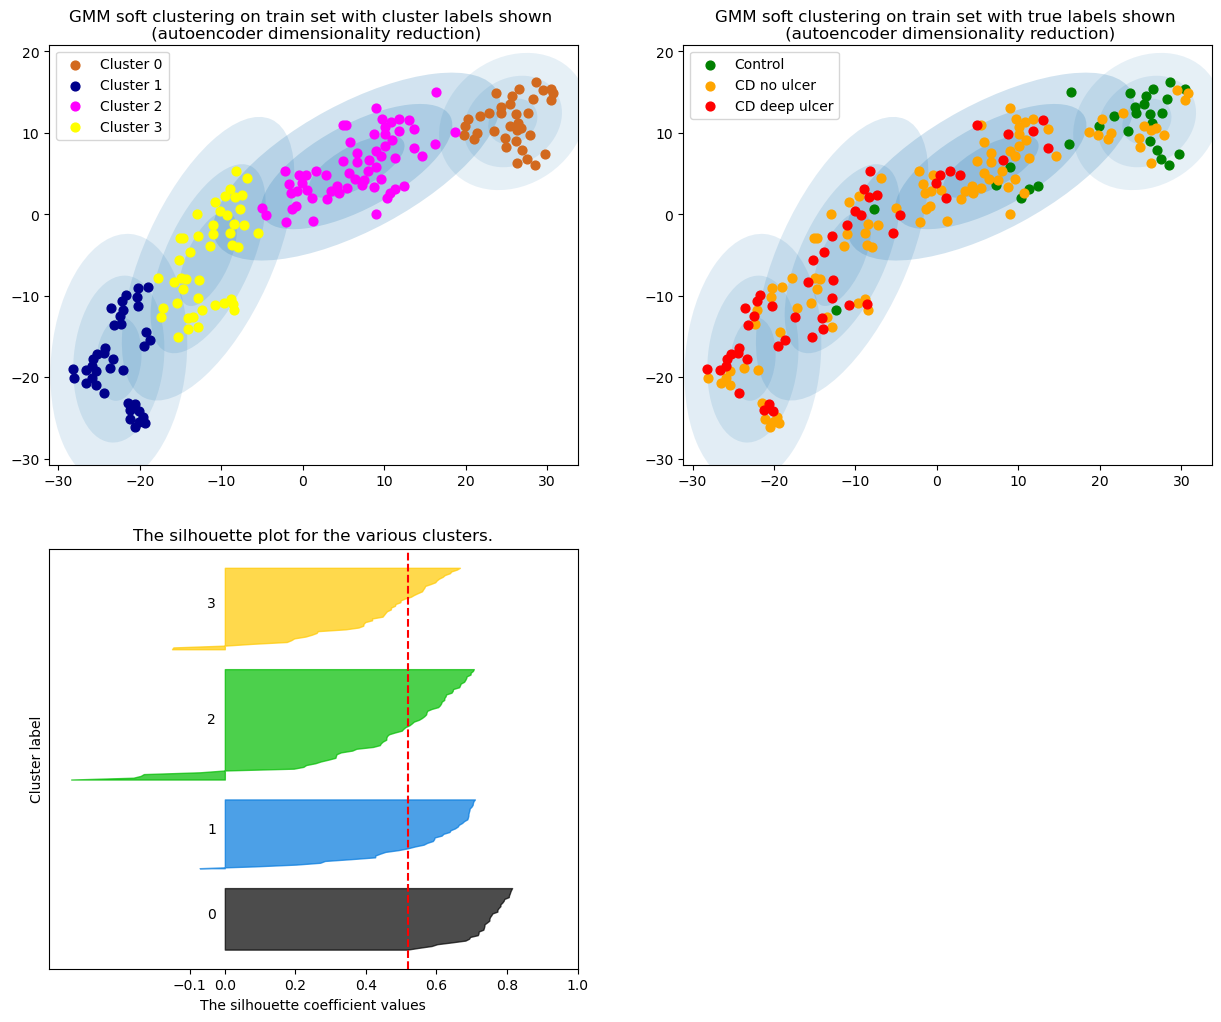

The average silhouette_score is : 0.51898056


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 50


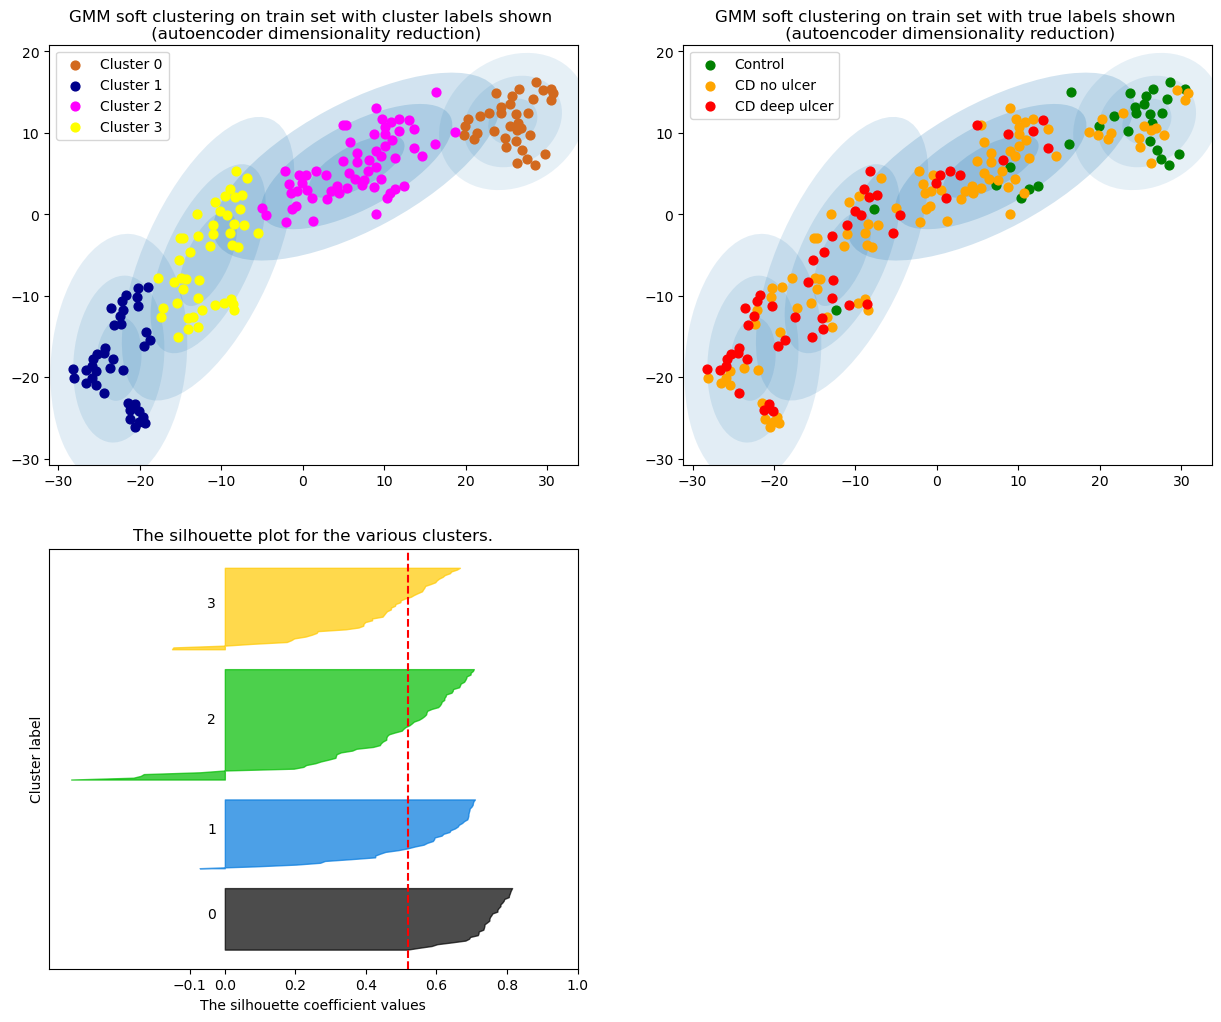

The average silhouette_score is : 0.51898056


C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


Perplexity = 70


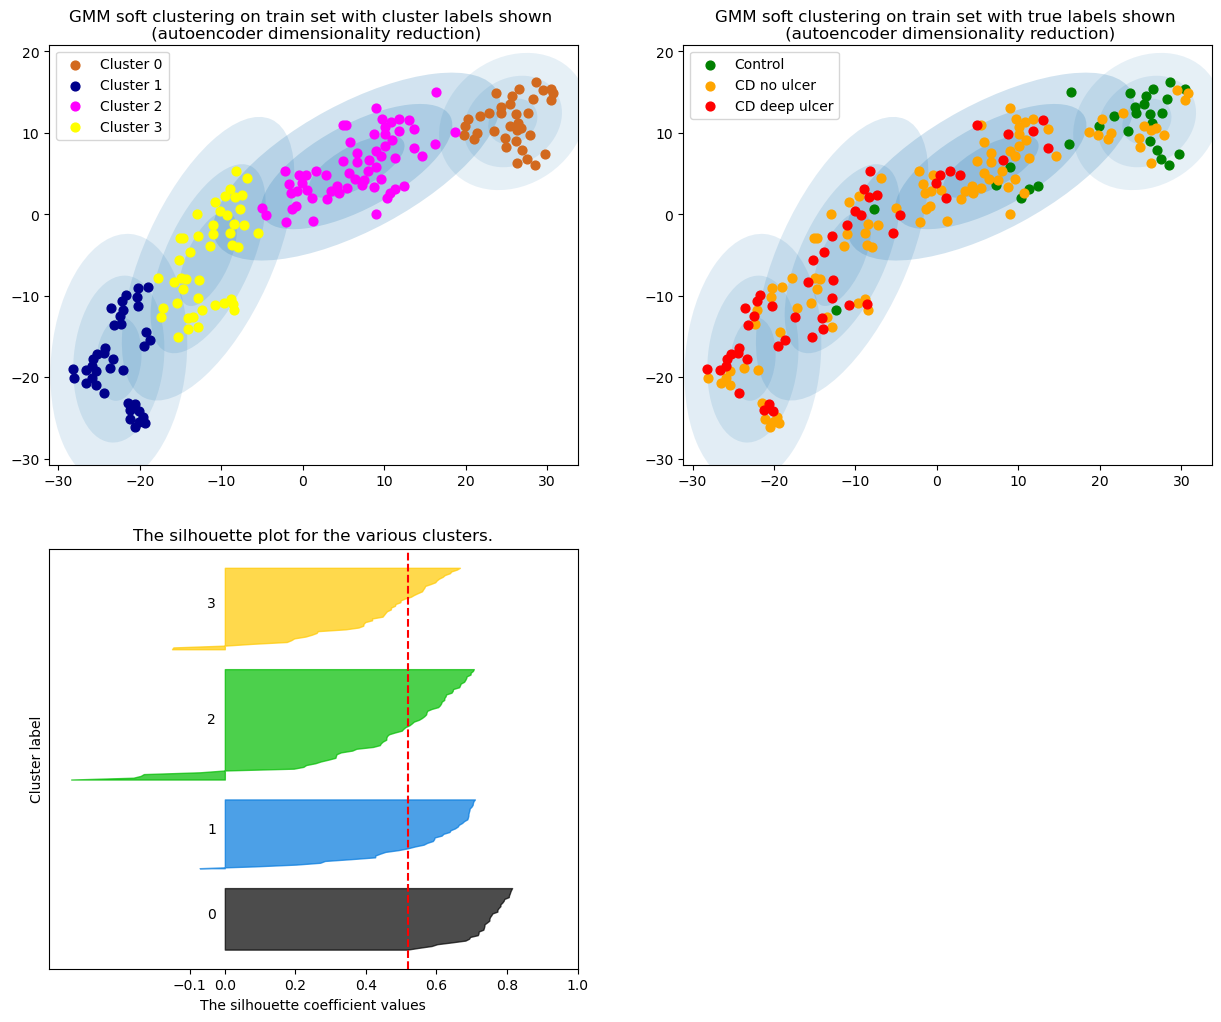

The average silhouette_score is : 0.51898056


In [223]:
perplexities = [10, 20, 50, 70]
# perplexity = 24
for perplexity in perplexities:
    gmm_ae, X_train_ae, X_test_ae = fit_gmm(full_ae_dataset, perplexity, num_c)
    print("Perplexity =",perplexity)
    plot_gmm(gmm_ae, X_train_ae, train_disease_labels, "autoencoder", num_c=num_c, plot_sil=True)

### Testing

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[label_set==i, 0], X[label_set==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


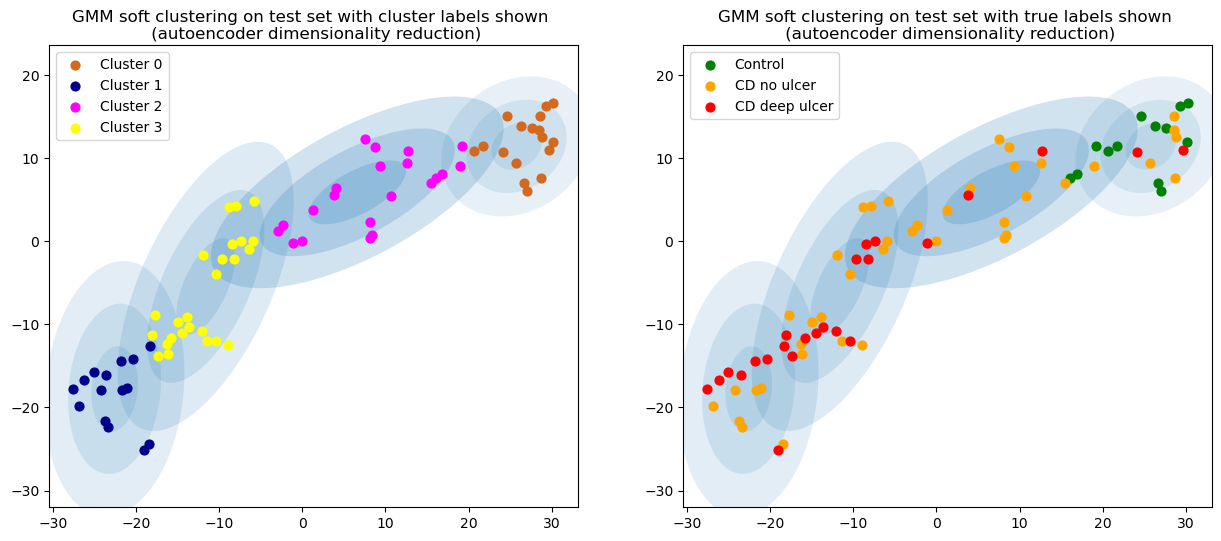

In [224]:
perplexity = 24
gmm_ae, X_train_ae, X_test_ae = fit_gmm(full_ae_dataset, perplexity, num_c)
gmm_labels_ae = plot_gmm(gmm_ae, X_test_ae, test_disease_labels, "autoencoder", num_c=num_c, test=True)

In [319]:
# np.where(X_test_ae >-30 )
# and X_test_ae[0] <-20
# (X_test_ae > -30 && X_test_ae < -20).all()
# y.logical_and(a, b)
# (X_test_ae[:,0] > -30) and (X_test_ae[:,1] < -20)
arr = np.logical_and(X_test_ae[:,0] < -20, X_test_ae[:,1] < -12, X_test_ae[:,1] > -20)
np.where(arr)

(array([ 2,  6,  8, 15, 16, 18, 36, 51, 54, 59, 63, 74], dtype=int64),)

In [322]:
X_test_ae[18,:]

array([-21.833607, -14.429554], dtype=float32)

## Process GMM cluster models

In [225]:
import scipy.stats
from scipy.stats import multivariate_normal


In [226]:
# vis
# x, y = np.mgrid[0:30:.01, 0:30:.01]
# pos = np.dstack((x, y))
# fig2 = plt.figure()
# ax2 = fig2.add_subplot(111)
# # for i in range(2):
# ax2.contourf(x, y, comps[0].pdf(pos))
# ax2.contourf(x, y, comps[2].pdf(pos))

In [227]:
def get_amount_matrix_gmm(gmm, X_train, train_disease_labels):
    mu, covar, w = gmm.means_, gmm.covariances_, gmm.weights_
    # print("means:",mu)
    # print("covariances_:",covar)
    # print("weights_:",w)
    
    comps = [multivariate_normal(mu[i], covar[i]) for i in range(num_c)]
    
    # make matrix to record amount of each class in each mixture component
    amounts = np.zeros((3, num_c))
    
    
    classes = ["control", "CD_no_ulcer", "CD_deep_ulcer"]
    for c, cls in enumerate(classes):
        for i, comp in enumerate(comps): # add up contributions for each component
            weight = w[i]
            pts = X_train[train_disease_labels==c]
            curr_sum = np.sum(comp.pdf(pts)) * weight
            amounts[c][i] = curr_sum
    print(amounts)
    #                cluster 0, cluster 1, cluster 2, cluster 3
    # control 
    # CD no ulcer
    # CD deep ulcer
    
    return amounts

In [228]:
def final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels):
    # process
    amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
    assignments, couple = process_clusters(amounts, X_train, num_c)
    # retrieve clusters
    gmm_labels = gmm.predict(X_test)
    test_set_clusters = get_final_clusters(assignments, couple, gmm_labels)
    
    return test_set_clusters



### Apply resulting models to test sets

In [229]:
# gmm_labels_list = [gmm_labels_ae, gmm_labels_pca]
gmm_models_list = [gmm_ae, gmm_pca]
train_set_list = [X_train_ae, X_train_pca]
test_set_list = [X_test_ae, X_test_pca]


In [230]:
# X_test_ae

[[3.44425608e-02 2.51282490e-06 8.10837699e-03 2.38645104e-03]
 [2.52158784e-02 1.85060671e-02 7.27648180e-02 2.85801795e-02]
 [1.33005274e-06 2.41975945e-02 2.03018423e-02 2.31364980e-02]]
initial cls assignments: [0 2 1]
[[1.50846395e-002 6.20783152e-117 2.74224434e-003 1.37757009e-002]
 [1.13991822e-002 2.09249474e-002 3.84224678e-002 6.23735769e-002]
 [6.67803127e-004 1.15754591e-002 4.03989222e-002 2.10052750e-002]]
initial cls assignments: [0 3 2]


C:\Users\shard\AppData\Local\Temp\ipykernel_1320\4135661383.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\4135661383.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2)
C:\Users\shard\AppData\Local\Temp\ipykernel_1320\1104872636.py:21: Matplo

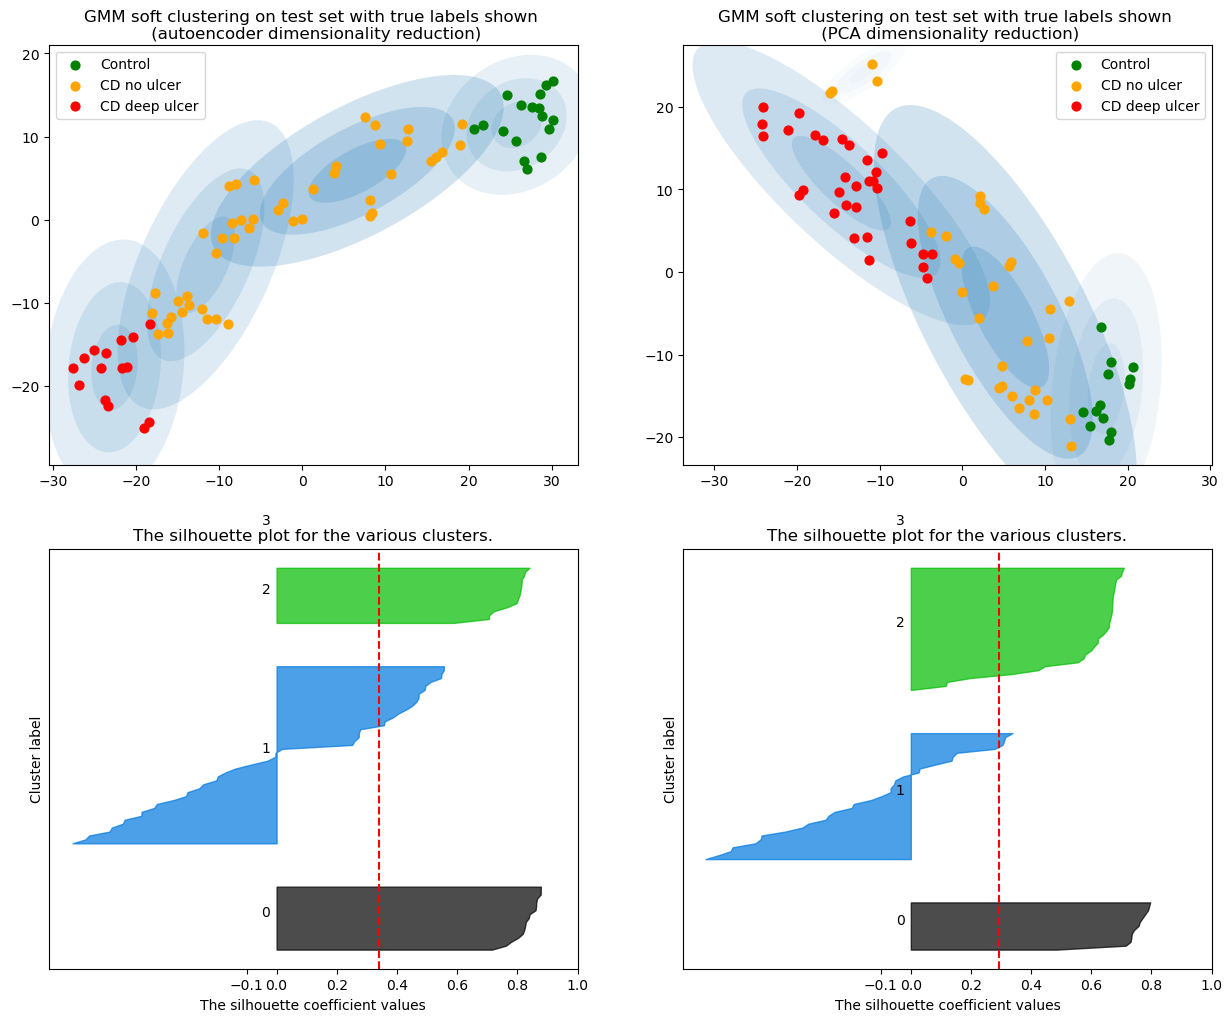

Autoencoder: average silhouette score = 0.34078598
PCA: average silhouette score = 0.29188654


In [231]:
def plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c):
#         left = -8
#         right = 8
#         ax.set_xlim(left, right)
#         ax.set_ylim(left, right)
        
        
#         if i==0:
#             num_clusters = num_c
#             cluster_names = ["Cluster " + str(i) for i in range(num_clusters)]
#             colours = ["chocolate", "darkblue", "magenta", "yellow", "blue"]
#             ax.set_title("GMM soft clustering on " + dset + " set with cluster labels shown \n (" + reduction + " dimensionality reduction)",
#                          wrap=True)
#         else:
#     fig, ax = plt.subplots()
    (fig, subplots) = plt.subplots(2, 2, figsize=(15, 12))
    reduction = ["autoencoder", "PCA"]
    final_clusters_lst = []
    for i in range(len(gmm_models_list)):
#         print(i)
        ax = subplots[0][i]
        gmm = gmm_models_list[i]
#         gmm_labels = gmm_labels_list[i]
        X_train = train_set_list[i]
        X_test = test_set_list[i]
#         amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
#         assignments, couple = process_clusters(amounts, X_train, num_c)
#         test_set_clusters = get_final_clusters(assignments, couple, gmm_labels)
        test_set_clusters = final_gmm_model_get_clusters(gmm, X_train, X_test, train_disease_labels)
#         print("gmmlabels:",gmm_labels)
#         print("tsclusters:",test_set_clusters)
#         print("asgn:",assignments)
        final_clusters_lst.append(test_set_clusters)




        reduc = reduction[i]
        num_clusters = 3
        cluster_names = ["Control", "CD no ulcer", "CD deep ulcer"]
        colours = ["green", "orange", "red"]
        ax.set_title("GMM soft clustering on test set with true labels shown \n (" + reduc + " dimensionality reduction)",
                    wrap=True)

        for i in range(num_clusters):
            ax.scatter(X_test[test_set_clusters==i, 0], X_test[test_set_clusters==i, 1], c=colours[i], label=cluster_names[i], s=40, cmap='viridis', zorder=2) 

        ax.axis('equal')


        w_factor = 0.2 / gmm.weights_.max()
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)
        ax.legend()
        
    s_avgs = []
    for j in range(2):
        ax = subplots[1][j]
        X_test = test_set_list[j]
        test_clusters = final_clusters_lst[j]

        silhouette_avg, sample_silhouette_values = compute_silh_scores(X_test, test_clusters)
        s_avgs.append(silhouette_avg)
        plot_silhouette(num_c, test_clusters, sample_silhouette_values, silhouette_avg, ax)
        
        
    plt.show()

    print("Autoencoder: average silhouette score =",s_avgs[0])
    print("PCA: average silhouette score =",s_avgs[1])

    return final_clusters_lst
        
final_clusters_gmm_ae, final_clusters_gmm_pca = plot_final_gmm_models(gmm_models_list, train_set_list, test_set_list, num_c)

3rd graph - substructure clustering processed in combination with true labels to obtain final 3 cluster clustering; model can now be easily coupled to shap - why better than simple k=3 clustering

## Find class probabilities from cluster model

In [232]:
def get_probs(point, comps, assignments, w):
    probs = []
    for elem in assignments:
        p_cand = []
        for cluster in elem:
            p = comps[cluster].pdf(point) * w[cluster]
#             print("p:",p)
            p_cand.append(p)
#         print(p_cand)
        p = max(p_cand)
        probs.append(p)
        
    return probs

def sum_to_one(vals): 
#     print(t, u)
    return vals / vals.sum()

def softmax(x): 
    return np.exp(x)/sum(np.exp(x))



In [292]:
def get_proba(gmm, assignments, X_test):
    # GMM mixture component distributions
    mu, covar, w = gmm.means_, gmm.covariances_, gmm.weights_
    # print("means:",mu)
    # print("covariances_:",covar)
    # print("weights_:",w)
    comps = [multivariate_normal(mu[i], covar[i]) for i in range(num_c)]

    X_test = X_test.tolist()
    new_list = []
    for point in X_test:
        probs = get_probs(point, comps, assignments, gmm.weights_)
#         print(probs)
        new_list.append(probs)
    pdf_vals = np.asarray(new_list)
#     pdf_vals = -np.log(pdf_vals)
    
#     plt.figure()
#     xr = np.arange(len(pdf_vals))
#     plt.scatter(xr, pdf_vals[:,0])
#     plt.scatter(xr, pdf_vals[:,1])
#     plt.scatter(xr, pdf_vals[:,2])
#     plt.show()

    # rescale so adds up to 1
#     proba = pdf_vals.copy()
#     for i in range(len(proba)):
#         row = proba[i,:]
#         rescaled = softmax(row)

#         proba[i,:] = rescaled
    proba = pdf_vals
    
    return proba

In [234]:
amounts = get_amount_matrix_gmm(gmm_ae, X_train_ae, train_disease_labels)
assignments_ae, couple_ae = process_clusters(amounts, X_train_ae, num_c)
assignments_ae

[[3.44425608e-02 2.51282490e-06 8.10837699e-03 2.38645104e-03]
 [2.52158784e-02 1.85060671e-02 7.27648180e-02 2.85801795e-02]
 [1.33005274e-06 2.41975945e-02 2.03018423e-02 2.31364980e-02]]
initial cls assignments: [0 2 1]


[[0], [2, 3], [1]]

In [235]:
amounts = get_amount_matrix_gmm(gmm_pca, X_train_pca, train_disease_labels)
assignments_pca, couple_pca = process_clusters(amounts, X_train_pca, num_c)
assignments_pca

[[1.50846395e-002 6.20783152e-117 2.74224434e-003 1.37757009e-002]
 [1.13991822e-002 2.09249474e-002 3.84224678e-002 6.23735769e-002]
 [6.67803127e-004 1.15754591e-002 4.03989222e-002 2.10052750e-002]]
initial cls assignments: [0 3 2]


[[0], [3, 1], [2]]

In [236]:
# gmm = gmm_ae
# assignments = assignments_ae

In [237]:
gmm_ae_prob = get_proba(gmm_ae, assignments_ae, X_test_ae)

In [238]:
gmm_pca_prob = get_proba(gmm_pca, assignments_pca, X_test_pca)

## Evaluation of final clustering models

### Mutual information scores

In [239]:
from sklearn.metrics import adjusted_mutual_info_score as mut_info

In [240]:
test_disease_labels # true clusters to which we compare

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1,
       1, 2, 2, 0, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1,
       0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2])

#### GMM

In [241]:

final_clusters_gmm_ae

array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1,
       0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1])

In [242]:
final_clusters_gmm_pca

array([0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0,
       1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2])

In [243]:

# Autoencoder
mut_info(test_disease_labels, final_clusters_gmm_ae)  

0.1548224744191735

In [244]:
# PCA
mut_info(test_disease_labels, final_clusters_gmm_pca)  

0.13970000200413626

#### KMeans

In [245]:
final_clusters_ae

array([0, 1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, 2, 2,
       0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1])

In [246]:
final_clusters_pca

array([0, 0, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1])

In [247]:

# Autoencoder
mut_info(test_disease_labels, final_clusters_ae)  

0.2641261562627138

In [248]:
# PCA
mut_info(test_disease_labels, final_clusters_pca)  

0.2012348274069471

Autoencoder does better in both cases

## Retrieving probabilities across classes using GMM model

In [249]:
def save_gmm(gmm, reduction_type):
    # save to file
    gmm_name = 'gmm_' + reduction_type
    np.save(gmm_name + '_weights', gmm.weights_, allow_pickle=False)
#     print('Saved ' + gmm_name + '_weights.npy')
    np.save(gmm_name + '_means', gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', gmm.covariances_, allow_pickle=False)
    
def load_gmm(gmm_name):
    # reload
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    
    return loaded_gmm


In [250]:
full_pca_dataset.iloc[split_pt:,:] = full_pca_dataset.iloc[split_pt:,:]
full_pca_dataset

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,-1.400480,0.036085,0.633785,0.991954,1.244477,1.137486,0.029610,0.658527,1.078466,-0.619487,...,0.470832,0.133802,-0.203272,-0.410425,0.186449,0.298332,-0.400682,0.767596,0.619227,0.085812
168_CD_plain,0.343929,-0.897671,0.955659,-0.201677,0.422730,-0.572408,0.003687,0.056367,0.171045,0.062771,...,0.027877,-0.336420,-0.175358,0.370251,-0.039556,0.055334,0.058026,0.161180,0.149297,-0.265662
72_control,-2.307192,-0.267483,1.578081,0.496850,-0.234867,0.234571,0.184197,0.036992,-0.068803,-0.119890,...,0.183052,0.194263,0.234877,0.178692,0.362024,-0.116276,-0.019640,-0.014161,0.195361,-0.416527
120_control,0.352933,-1.007575,-0.545913,0.208984,-0.308962,-0.011900,-0.357425,0.045246,-0.176911,-0.057539,...,0.046615,0.026036,-0.092182,0.198564,0.214210,-0.068817,0.149709,-0.144454,-0.024551,-0.078279
258_CD_plain,-1.060160,-0.005791,-0.675548,0.336661,-0.086003,0.094171,-0.527973,-0.092358,0.061105,0.117648,...,-0.081974,-0.346245,0.006149,0.066966,-0.062242,0.032586,0.045676,0.160777,-0.083701,-0.201276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,-0.606965,0.901155,-0.129386,0.376657,0.633053,-0.646787,-0.025191,-0.577871,0.226875,0.216126,...,-0.162954,0.418765,-0.327443,-0.092706,0.230622,-0.039201,0.249956,-0.195686,0.234317,-0.084708
279_CD_plain,3.506419,1.522807,0.699719,-0.745470,-0.580558,0.578631,-0.566366,-0.566195,0.731688,0.033518,...,0.288631,0.022524,0.294265,0.292919,0.315232,0.024599,-0.103006,0.091974,-0.242777,0.207561
179_CD_plain,-1.303572,0.383862,-0.789780,0.275842,0.342230,-0.217623,-0.132509,0.171328,-0.148949,0.083994,...,0.249937,-0.210734,-0.017859,-0.011368,0.111694,-0.060908,0.098905,-0.038497,-0.109074,0.081559


In [251]:
full_ds

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [252]:

def gmm_prediction_ae(x_test_scaled):
    # preprocessing

    full_dataset = full_ds.copy()
    split_pt = len(full_dataset) - len(x_test_scaled)
    full_dataset.iloc[split_pt:,:] = x_test_scaled

        
    # dim redction - autoencoder
    full_ae_dataset = ae_encode_dataset(full_dataset)
    
    # tsne
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_ae_dataset)
    X_test = X[split_pt:]
    
    
    filename_assignments = "autoencoder_assignments"
    load_gmm_name = "gmm_autoencoder"
    # load gmm model
    gmm = load_gmm(load_gmm_name)
    # load assignments
    with open(filename_assignments, "rb") as fp:   # Unpickling
        assignments = pickle.load(fp)
    return get_proba(gmm, assignments, X_test)

def gmm_model_get_prediction_ae(x_test_scaled):
    if len(x_test_scaled) <= len(full_ds):
        return gmm_prediction_ae(x_test_scaled)
    else:
        full_resp = np.empty((0,3))
        for i in range(0, len(x_test_scaled), len(full_ds)):
            end = i + len(full_ds)
            if end > len(x_test_scaled):
                end = len(x_test_scaled)
            next_resp = gmm_prediction_ae(x_test_scaled[i:end])
            full_resp = np.concatenate([full_resp, next_resp])
        return full_resp

In [253]:
def gmm_prediction_pca(x_test_scaled):
    # preprocessing
    full_dataset = full_ds.copy()
    split_pt = len(full_dataset) - len(x_test_scaled)
    full_dataset.iloc[split_pt:,:] = x_test_scaled
    
    # dim redction - PCA
    full_pca_dataset, _ = encode_pca(full_dataset)
    
    # tsne
    tsne = manifold.TSNE(
        n_components=2,
        init="random",
        random_state=0,
        perplexity=24,
        n_iter=750,
        method='exact'
    )
    X = tsne.fit_transform(full_pca_dataset)
    X_test = X[split_pt:]

    
    filename_assignments = "PCA_assignments"
    load_gmm_name = "gmm_PCA"
    # load gmm model
    gmm = load_gmm(load_gmm_name)
    # load assignments
    with open(filename_assignments, "rb") as fp:   # Unpickling
        assignments = pickle.load(fp)
    return get_proba(gmm, assignments, X_test)

def gmm_model_get_prediction_pca(x_test_scaled):
    if len(x_test_scaled) <= len(full_ds):
        return gmm_prediction_pca(x_test_scaled)
    else:
        full_resp = np.empty((0,3))
        for i in range(0, len(x_test_scaled), len(full_ds)):
            end = i + len(full_ds)
            if end > len(x_test_scaled):
                end = len(x_test_scaled)
            next_resp = gmm_prediction_pca(x_test_scaled[i:end])
            full_resp = np.concatenate([full_resp, next_resp])
        return full_resp

In [254]:
def final_gmm_model_get_prob(gmm, X_train, X_test, train_disease_labels, reduction_type, save = False):
    # process
    amounts = get_amount_matrix_gmm(gmm, X_train, train_disease_labels)
    assignments, couple = process_clusters(amounts, X_train, num_c)
    if save:
        # save gmm model
        save_gmm(gmm, reduction_type)
        # save assignments
        filename = reduction_type + "_assignments"
        with open(filename, "wb") as fp:   #Pickling
            pickle.dump(assignments, fp)
    # retrieve clusters
    probs = get_proba(gmm, assignments, X_test)
    
    return probs


# def gmm_model_get_prediction_ae(x_test_scaled):
#     # preprocessing
#     # load full dataset
#     smaller_set = False
#     if len(x_test_scaled) < len(full_ds):
#         smaller_set = True
#         full_dataset = full_ds.copy()
#         split_pt = len(full_dataset) - len(x_test_scaled)
#         full_dataset.iloc[split_pt:,:] = x_test_scaled
#     else:
#         full_dataset = x_test_scaled.copy()
        
#     # dim redction - autoencoder
#     full_ae_dataset = ae_encode_dataset(full_dataset)
    
#     # tsne
#     tsne = manifold.TSNE(
#         n_components=2,
#         init="random",
#         random_state=0,
#         perplexity=24,
#         n_iter=750,
#         method='exact'
#     )
#     X = tsne.fit_transform(full_ae_dataset)
#     if smaller_set:
#         X_test = X[split_pt:]
#     else:
#         X_test = X
    
    
#     filename_assignments = "autoencoder_assignments"
#     load_gmm_name = "gmm_autoencoder"
#     # load gmm model
#     gmm = load_gmm(load_gmm_name)
#     # load assignments
#     with open(filename_assignments, "rb") as fp:   # Unpickling
#         assignments = pickle.load(fp)
#     return get_proba(gmm, assignments, X_test)

# def gmm_model_get_prediction_pca(x_test_scaled):
#     smaller_set = False
#     # preprocessing
#     if len(x_test_scaled) < len(full_ds):
#         smaller_set = True
#         full_dataset = full_ds.copy()
#         split_pt = len(full_dataset) - len(x_test_scaled)
#         full_dataset.iloc[split_pt:,:] = x_test_scaled
#     else:
#         full_dataset = x_test_scaled.copy()
    
#     # dim redction - PCA
#     full_pca_dataset, _ = encode_pca(full_dataset)
    
#     # tsne
#     tsne = manifold.TSNE(
#         n_components=2,
#         init="random",
#         random_state=0,
#         perplexity=24,
#         n_iter=750,
#         method='exact'
#     )
#     X = tsne.fit_transform(full_pca_dataset)
#     if smaller_set:
#         X_test = X[split_pt:]
#     else:
#         X_test = X
    
#     filename_assignments = "PCA_assignments"
#     load_gmm_name = "gmm_PCA"
#     # load gmm model
#     gmm = load_gmm(load_gmm_name)
#     # load assignments
#     with open(filename_assignments, "rb") as fp:   # Unpickling
#         assignments = pickle.load(fp)
#     return get_proba(gmm, assignments, X_test)

## GMM prediction with autoencoder dimensionality reduction

In [255]:
# save required components
gmm_ae_prob = final_gmm_model_get_prob(gmm_ae, X_train_ae, X_test_ae, train_disease_labels, "autoencoder", save=False)
# gmm_ae_prob

[[3.44425608e-02 2.51282490e-06 8.10837699e-03 2.38645104e-03]
 [2.52158784e-02 1.85060671e-02 7.27648180e-02 2.85801795e-02]
 [1.33005274e-06 2.41975945e-02 2.03018423e-02 2.31364980e-02]]
initial cls assignments: [0 2 1]


In [256]:
# x_test_scaledvv = np.empty((0,219))
# for i in range(100):
#     x_test_scaledvv = np.concatenate([x_test_scaledvv, x_test_scaled.values])
# x_test_scaledvv.shape

In [257]:
# x_test_scaledvv = pd.concat([x_test_scaled,x_test_scaled,x_test_scaled,x_test_scaled])
# x_test_scaledvv.shape

In [258]:
# x_test_scaledv = x_test_scaled.copy()
# for i in range(5):
#     x_test_scaledv = pd.concat([x_test_scaledv,x_test_scaledv])
    
# x_test_scaled.shape

In [259]:

gmm_ae_prob = gmm_model_get_prediction_ae(x_test_scaled)
# gmm_ae_prob

<class 'pandas.core.frame.DataFrame'>


In [260]:
gmm_ae_prob

array([[0.33380342, 0.33309853, 0.33309805],
       [0.33323792, 0.33352416, 0.33323792],
       [0.33325253, 0.3332526 , 0.33349487],
       [0.33323764, 0.33352472, 0.33323764],
       [0.33321097, 0.33357805, 0.33321097],
       [0.33347732, 0.33326135, 0.33326133],
       [0.33322643, 0.33322656, 0.333547  ],
       [0.33322952, 0.3333601 , 0.33341038],
       [0.33316115, 0.33319946, 0.33363939],
       [0.33352848, 0.33323581, 0.33323571],
       [0.33320268, 0.33356649, 0.33323084],
       [0.33305708, 0.33388583, 0.33305708],
       [0.33326152, 0.33347937, 0.33325912],
       [0.33326937, 0.33346121, 0.33326942],
       [0.33320812, 0.33358376, 0.33320812],
       [0.33310902, 0.33311043, 0.33378055],
       [0.33316002, 0.33316159, 0.3336784 ],
       [0.33307775, 0.33384449, 0.33307776],
       [0.3331185 , 0.3331307 , 0.33375081],
       [0.33323059, 0.33348736, 0.33328205],
       [0.33316767, 0.33366466, 0.33316767],
       [0.33322038, 0.33355924, 0.33322038],
       [0.

## GMM prediction with PCA dimensionality reduction

In [261]:
# save required components
gmm_pca_prob = final_gmm_model_get_prob(gmm_pca, X_train_pca, X_test_pca, train_disease_labels, "PCA", save=False)

[[1.50846395e-002 6.20783152e-117 2.74224434e-003 1.37757009e-002]
 [1.13991822e-002 2.09249474e-002 3.84224678e-002 6.23735769e-002]
 [6.67803127e-004 1.15754591e-002 4.03989222e-002 2.10052750e-002]]
initial cls assignments: [0 3 2]


In [262]:

gmm_pca_prob = gmm_model_get_prediction_pca(x_test_scaled)
gmm_pca_prob.shape

(78, 3)

In [263]:
gmm_pca_prob

array([[0.33356858, 0.33323682, 0.3331946 ],
       [0.33347909, 0.33326436, 0.33325654],
       [0.3332562 , 0.3332562 , 0.33348761],
       [0.33316908, 0.33361278, 0.33321814],
       [0.33315142, 0.33368497, 0.33316362],
       [0.33349161, 0.33325494, 0.33325345],
       [0.33324688, 0.33324688, 0.33350625],
       [0.33325606, 0.33325732, 0.33348662],
       [0.33325953, 0.33326027, 0.3334802 ],
       [0.33374801, 0.33313667, 0.33311532],
       [0.33325921, 0.33326447, 0.33347632],
       [0.33319797, 0.33360351, 0.33319852],
       [0.33326278, 0.33347437, 0.33326285],
       [0.33321475, 0.33321601, 0.33356924],
       [0.33322001, 0.33332334, 0.33345665],
       [0.33317394, 0.33317395, 0.33365211],
       [0.33326828, 0.33345823, 0.33327349],
       [0.33321327, 0.33321333, 0.3335734 ],
       [0.3331685 , 0.33316861, 0.33366289],
       [0.3333142 , 0.33332745, 0.33335835],
       [0.33321568, 0.33351292, 0.33327141],
       [0.33318129, 0.33359537, 0.33322333],
       [0.